## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Find correction coefficients

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
from tqdm import tqdm
from moviepy.editor import VideoFileClip

%matplotlib inline

print("Done")

Done


Computer camera calibration coefficients

In [10]:
nx, ny = 9, 6  #chessboard size

imagepoints = []
objectpoints = []

objp = np.zeros((nx * ny, 3), dtype=np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

images = glob.glob("camera_cal/calibration*")

with tqdm(total=len(images), desc="Calibration camera") as pbar:
    for image_path in images:
        img = cv2.imread(image_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objectpoints.append(objp)
            imagepoints.append(corners)
        pbar.update(1)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, (720, 1280), None, None)

print("Done")

Calibration camera:   0%|          | 0/20 [00:00<?, ?it/s]

Calibration camera:   5%|▌         | 1/20 [00:00<00:08,  2.18it/s]

Calibration camera:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]

Calibration camera:  15%|█▌        | 3/20 [00:02<00:10,  1.62it/s]

Calibration camera:  20%|██        | 4/20 [00:02<00:08,  1.90it/s]

Calibration camera:  35%|███▌      | 7/20 [00:02<00:05,  2.45it/s]

Calibration camera:  40%|████      | 8/20 [00:03<00:05,  2.25it/s]

Calibration camera:  45%|████▌     | 9/20 [00:03<00:04,  2.47it/s]

Calibration camera:  50%|█████     | 10/20 [00:03<00:03,  2.92it/s]

Calibration camera:  55%|█████▌    | 11/20 [00:04<00:02,  3.08it/s]

Calibration camera:  60%|██████    | 12/20 [00:04<00:02,  3.27it/s]

Calibration camera:  65%|██████▌   | 13/20 [00:04<00:02,  3.46it/s]

Calibration camera:  70%|███████   | 14/20 [00:04<00:01,  3.84it/s]

Calibration camera:  75%|███████▌  | 15/20 [00:05<00:01,  3.33it/s]

Calibration camera:  80%|████████  | 16/20 [00:05<00:01,  3.08it/s]

Calibration camera:  85%|████████▌ | 17/20 [00:06<00:01,  2.73it/s]

Calibration camera:  90%|█████████ | 18/20 [00:06<00:00,  2.20it/s]

Calibration camera:  95%|█████████▌| 19/20 [00:07<00:00,  2.44it/s]

Calibration camera: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

Done


Result of calibration

Done


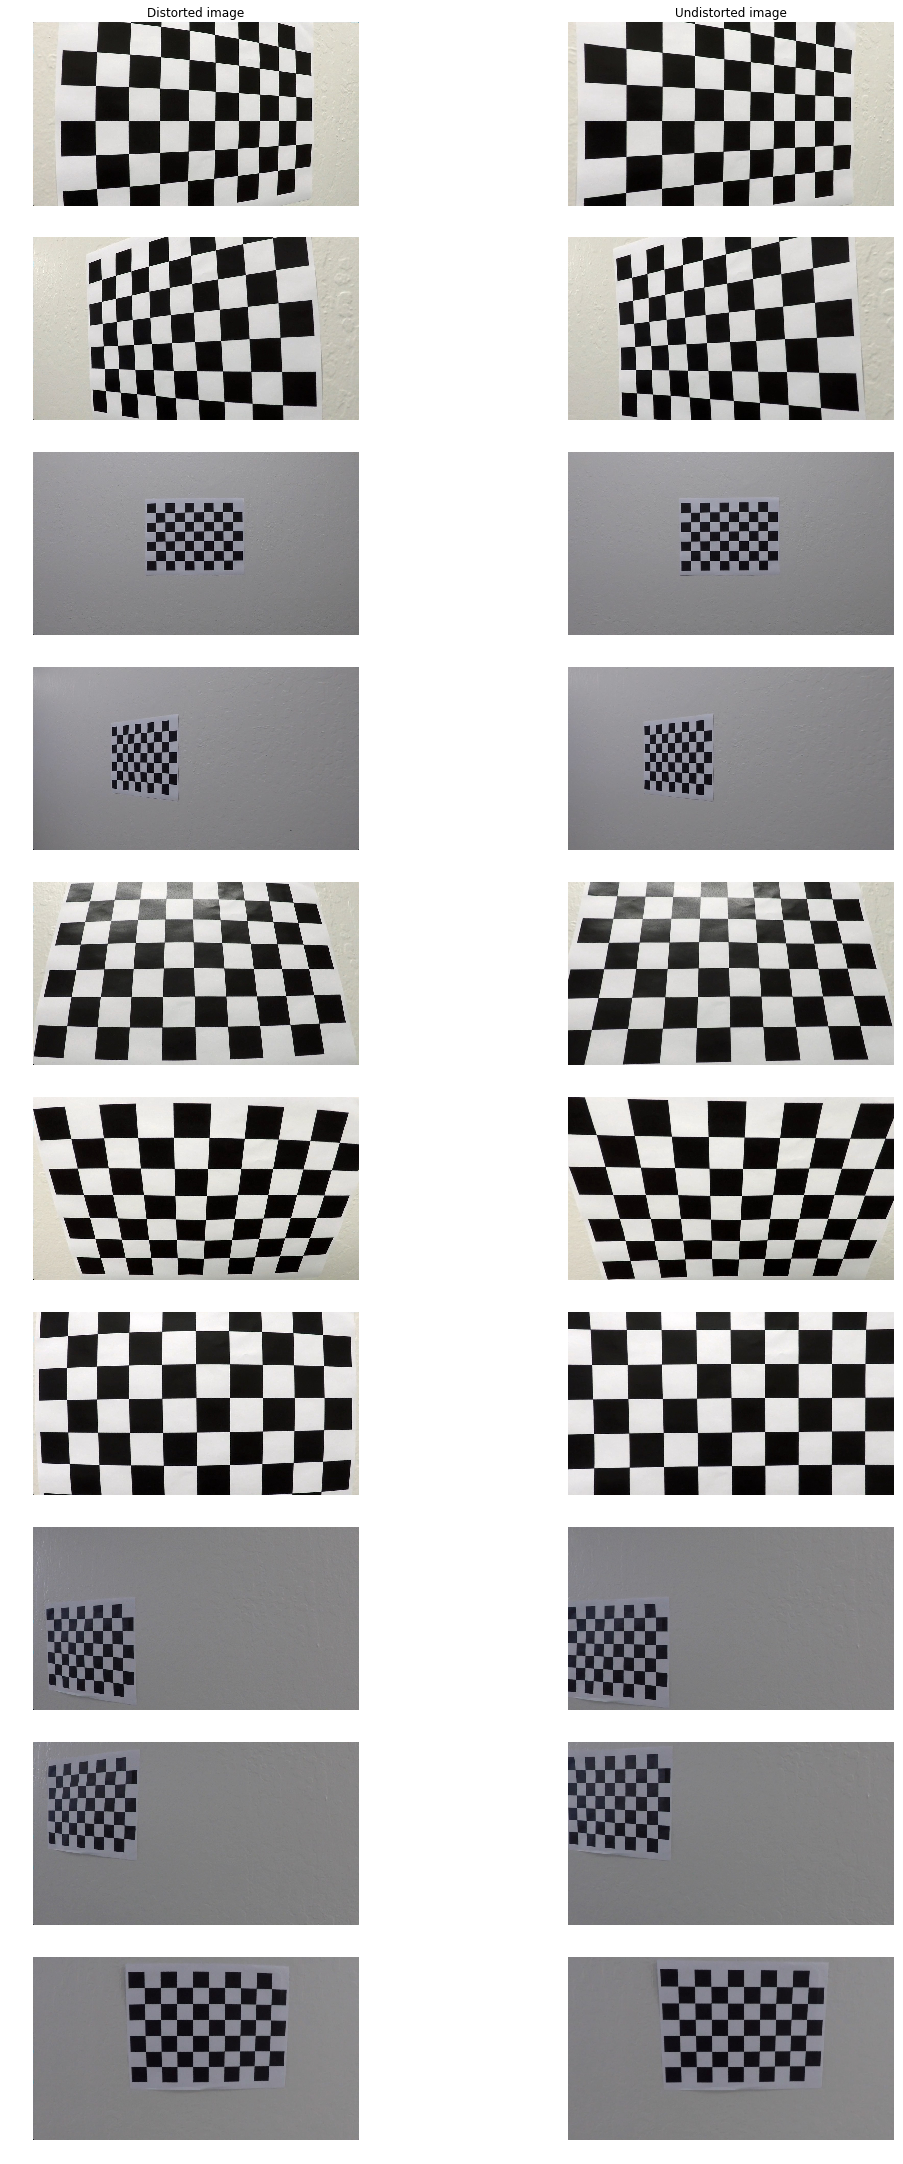

In [9]:
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


rows = len(images) // 2
columns = 2

fig, ax = plt.subplots(rows, columns)
fig.set_size_inches(15, 30)
fig.tight_layout()

dist_img = mpimg.imread("camera_cal/calibration1.jpg")
undist_img = undist(dist_img)

index = 0

for row in range(rows):
    if row == 0:
        ax[0][0].set_title("Distorted image")
        ax[0][1].set_title("Undistorted image")

    ax[row][0].axis("off")
    ax[row][1].axis("off")
    
    img = mpimg.imread(images[index])
    ax[row][0].imshow(img)
    ax[row][1].imshow(undist(img))
    index += 1

print("Done")


### Example of correction test image

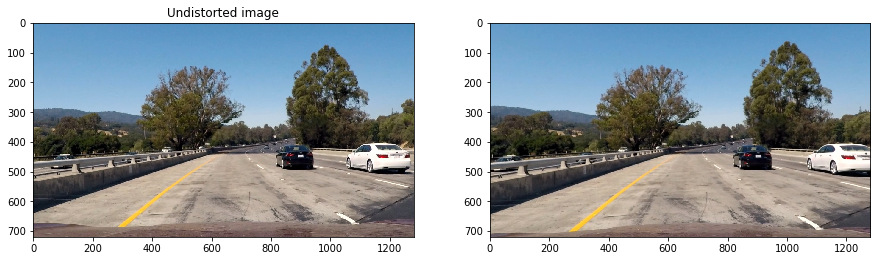

In [21]:
test_img = mpimg.imread("test_images/test1.jpg")
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 30)
ax[0].imshow(test_img)
ax[0].set_title("Original")
ax[1].imshow(undist(test_img))
ax[1].set_title("Corrected image")

##Create threshold binary image. 

There will be used two types of threshold binary image creation and his combination:
- Sobel operator
- Color threshold
- Sobel operator + color threshold

### Sobel operator
There are three methods how apply sobel operator :
- Apply sobel operator in direction horizonal or vertical (x, y)
- Operator Sobel apply in x and y directrion then computes the magnitude of the gradient
- Sobel operator which will be contain angle of line in the picture, will be used arctan

Done


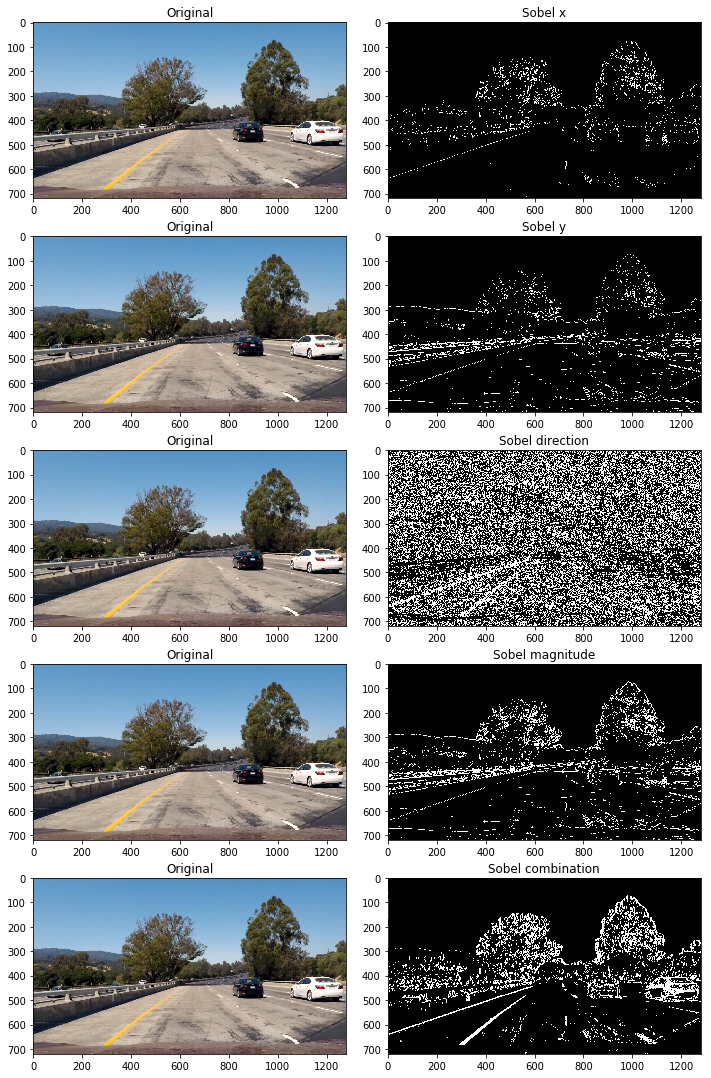

In [27]:
def sobel(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' ororient_x = 0
    orient_y = 0
    if orient == 'x':
        orient_x = 1
        orient_y = 0
    else:
        orient_x = 0
        orient_y = 1

    sobel_img = cv2.Sobel(gray, cv2.CV_64F, orient_x, orient_y, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled)
    sbinary[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


def sobel_mag(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  #x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)  #y
    # 3) Calculate the magnitude 
    sobel_res = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * sobel_res / np.max(sobel_res))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def sobel_dir(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


def sobel_comb(img, ksize=3, thresh=(20, 100), thresh_color=(0, 255)):
    sobel_x = sobel(img, orient='x', sobel_kernel=ksize, thresh=thresh)
    sobel_s = sobel_hls_select(img, thresh=thresh_color)
    combined_binary = np.zeros_like(sobel_x)
    combined_binary[(sobel_s == 1) | (sobel_x == 1)] = 1
    return combined_binary


test_img = mpimg.imread("test_images/test1.jpg")

sobelx_img = sobel(test_img, orient='x', thresh=(30, 100))
sobely_img = sobel(test_img, orient='y', thresh=(30, 100))
sobel_dir_img = sobel_dir(test_img, sobel_kernel=15, thresh=(0.7, 1.3))
sobel_mag_img = sobel_mag(test_img, sobel_kernel=3, thresh=(30, 100))
sobel_comb_img = sobel_comb(test_img, ksize=15, thresh=(20, 100), thresh_color=(180, 255))

rows = 5
cols = 2

fig, ax = plt.subplots(rows, cols)

fig.set_size_inches(10, 15)
fig.tight_layout()

for index in range(rows):
    ax[index][0].set_title("Original")
    ax[index][0].imshow(test_img)

ax[0][1].set_title("Sobel x")
ax[0][1].imshow(sobelx_img, cmap='gray')

ax[1][1].set_title("Sobel y")
ax[1][1].imshow(sobely_img, cmap='gray')

ax[2][1].set_title("Sobel direction")
ax[2][1].imshow(sobel_dir_img, cmap='gray')

ax[3][1].set_title("Sobel magnitude")
ax[3][1].imshow(sobel_mag_img, cmap='gray')

ax[4][1].set_title("Sobel combination")
ax[4][1].imshow(sobel_comb_img, cmap='gray')

print("Done")

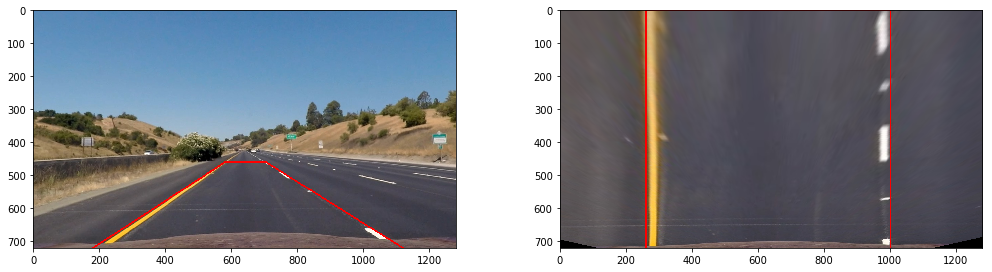

In [29]:
def bird_eye_transform(img, src, dst, width=1280, height=720):
    transform_matrix = cv2.getPerspectiveTransform(src, dst)
    transformed = cv2.warpPerspective(img, transform_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return transformed

src = [[180, 720], [580, 460], [705, 460], [1120, 720]]
dst = [[260, 720], [260, 0], [1000, 0], [1000, 720]]

fig, ax = plt.subplots(1, 2)
fig.tight_layout()
fig.set_size_inches(15, 10)
img = undist(mpimg.imread("test_images/straight_lines1.jpg"))
line_img = np.copy(img)
mask_points = np.array(src, dtype=np.int32).reshape((-1, 1, 2))
dst_line_points = np.array(dst, dtype=np.int32).reshape((-1, 1, 2))

transformed_img = bird_eye_transform(img, np.float32(src), np.float32(dst))

cv2.polylines(line_img, [mask_points], False, (255, 0, 0), thickness=3, lineType=cv2.FILLED)
cv2.polylines(transformed_img, [dst_line_points], False, (255, 0, 0), thickness=3, lineType=cv2.FILLED)

ax[0].imshow(line_img, cmap='gray')
ax[1].imshow(transformed_img, cmap='gray')


## Detect lane pixels and fit to find the lane boundary.

(1280,)


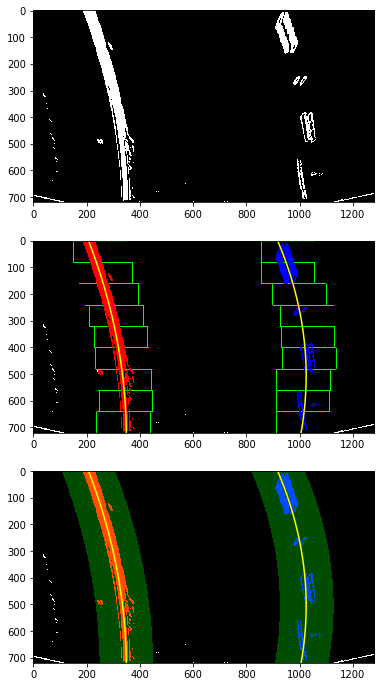

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Transform image and apply gradient threshold
def prepare_image(img):
    img = undist(img)
    img = bird_eye_transform(img, np.float32(src), np.float32(dst))
    img = sobel_comb(img, ksize=15, thresh=(20, 100), thresh_color=(180, 255))
    return img

def find_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    print(histogram.shape)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                      (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                      (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return (left_fit, right_fit, left_fitx, right_fitx, ploty, out_img)   

def find_lines_next_frame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return left_fit, right_fit, left_fitx, right_fitx, ploty, result

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(8, 12)
image = mpimg.imread("test_images/test2.jpg")
binary_warped = prepare_image(image)
ax[0].imshow(binary_warped, cmap="gray")

(left_fit, right_fit, left_fitx, right_fitx, ploty, out_img) = find_lines(binary_warped) 
(left_fit, right_fit, left_fitx, right_fitx, ploty, result) = find_lines_next_frame(binary_warped, left_fit, right_fit)   
   
ax[1].imshow(out_img)
ax[1].plot(left_fitx, ploty, color='yellow')
ax[1].plot(right_fitx, ploty, color='yellow')

ax[2].imshow(result)
ax[2].plot(left_fitx, ploty, color='yellow')
ax[2].plot(right_fitx, ploty, color='yellow')



## Determine the curvature of the lane and vehicle position with respect to center. 

(1280,)
1909.48617261 1253.37455978


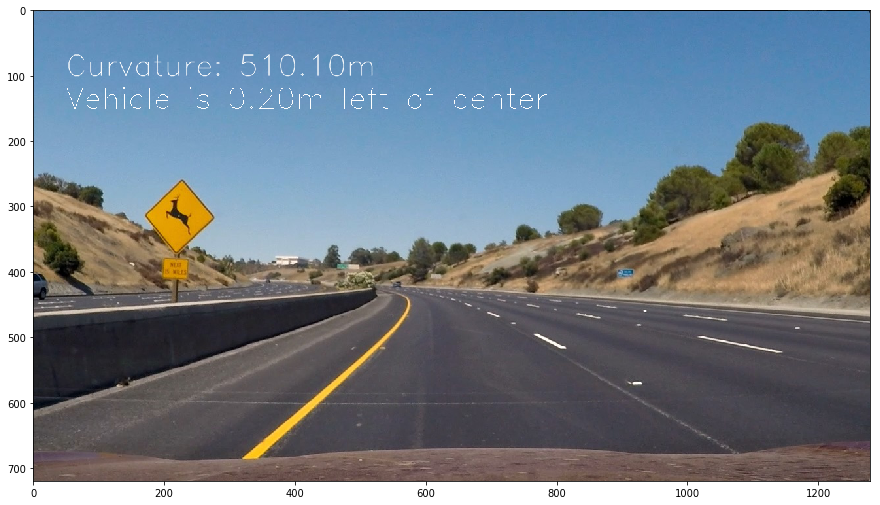

In [49]:
def curvature(left_fit, right_fit, leftx, rightx, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    print(left_curverad, right_curverad)

    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    curverad = (left_curverad + right_curverad) / 2

    rightx_int = right_fit[0] * 720 ** 2 + right_fit[1] * 720 + right_fit[2]
    leftx_int = left_fit[0] * 720 ** 2 + left_fit[1] * 720 + left_fit[2]

    position = (rightx_int + leftx_int) / 2
    distance_from_center = abs((640 - position) * xm_per_pix)

    return curverad, distance_from_center, position


def draw_curvature(img, curv, distance_from_center, position):
    cv2.putText(img, "Curvature: {0:.2f}m".format(curv), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255),
                lineType=cv2.LINE_AA)

    # Print distance from center on video
    if position > 640:
        cv2.putText(img, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, (255, 255, 255))
    else:
        cv2.putText(img, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255))
    return img

original_img = mpimg.imread("test_images/test2.jpg")
binary_warped = prepare_image(np.copy(original_img))
(left_fit, right_fit, right_fitx, left_fitx, ploty, debug_img) = find_lines(binary_warped)
(curv, distance_from_center, position) = curvature(left_fit, right_fit, left_fitx, right_fitx, ploty)
plt.figure(figsize=(15, 20))
plt.imshow(draw_curvature(original_img, curv, distance_from_center, position))


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


(1280,)
3136.26868739 1049.39795403
(720,)


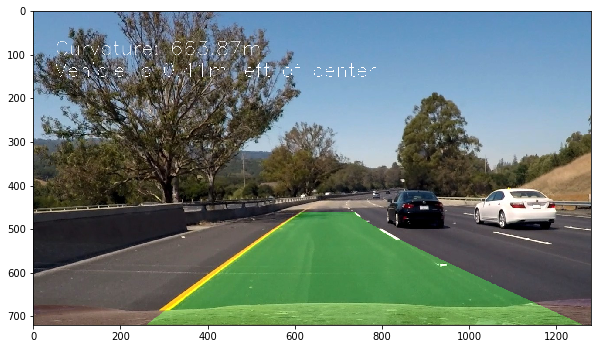

In [51]:
# Create an image to draw the lines on 


def draw_debug_info(image, binary_warped, left_fitx, right_fitx, ploty, curv, distance_from_center, position):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    print(right_fitx.shape)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    transform_matrix = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    newwarp = cv2.warpPerspective(color_warp, transform_matrix, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = draw_curvature(result, curv, distance_from_center, position)
    return result


def process_pipeline(img):
    binary_warped = prepare_image(img)
    (left_fit, right_fit, right_fitx, left_fitx, ploty, debug_img) = find_lines(binary_warped)
    curv, distance_from_center, position = curvature(left_fit, right_fit, right_fitx, left_fitx, ploty)
    img = draw_debug_info(img, binary_warped, left_fitx, right_fitx, ploty, curv, distance_from_center, position)
    return img


original_img = mpimg.imread("test_images/test6.jpg")
plt.figure(figsize=(10, 15))
plt.imshow(process_pipeline(original_img))


In [52]:
challenge_output = 'project_processed.mp4'
clip3 = VideoFileClip('project_video.mp4')
first_frame = clip3.get_frame(0)

(left_fitx, right_fitx, left_line, right_line, ploty, debug_img) = find_lines(prepare_image(first_frame))

def process_pipeline_next(img):
    binary_warped = prepare_image(img)
    global left_line, right_line
    (left_line, right_line, left_fitx, right_fitx, ploty, debug_img) = find_lines_next_frame(binary_warped, left_line, right_line)
    return draw_debug_info(image, binary_warped, left_fitx, right_fitx, ploty)


challenge_clip = clip3.fl_image(process_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(1280,)


(1280,)
1935.45777266 6119.09216108
(720,)
[MoviePy] >>>> Building video project_processed.mp4


[MoviePy] Writing video project_processed.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280,)


  0%|          | 1/1261 [00:00<04:45,  4.42it/s]

1935.45777266 6119.09216108
(720,)


  0%|          | 2/1261 [00:00<04:44,  4.43it/s]

(1280,)
1848.9257907 5770.67135475
(720,)
(1280,)
1748.82405667 2562.671205
(720,)


  0%|          | 3/1261 [00:00<04:19,  4.85it/s]

  0%|          | 4/1261 [00:00<04:20,  4.83it/s]

(1280,)
1679.73876967 2130.64922904
(720,)
(1280,)


  0%|          | 5/1261 [00:01<04:21,  4.81it/s]

  0%|          | 6/1261 [00:01<03:59,  5.24it/s]

1814.29817146 2219.32324559
(720,)
(1280,)
1812.03083869 2166.69467936
(720,)


  1%|          | 7/1261 [00:01<03:40,  5.69it/s]

  1%|          | 8/1261 [00:01<03:23,  6.16it/s]

(1280,)
1931.19913441 2397.38525362
(720,)
(1280,)
1948.51394773 7484.44609951
(720,)


  1%|          | 9/1261 [00:01<03:16,  6.36it/s]

  1%|          | 10/1261 [00:01<03:13,  6.45it/s]

(1280,)
2023.86097412 8150.37281563
(720,)
(1280,)
2070.24221337 6735.58742724
(720,)


  1%|          | 11/1261 [00:01<03:36,  5.77it/s]

  1%|          | 12/1261 [00:02<03:18,  6.29it/s]

(1280,)
2145.05733967 4899.92777946
(720,)
(1280,)
2379.88361425 47880.4392282
(720,)


  1%|          | 13/1261 [00:02<03:35,  5.80it/s]

(1280,)
2387.29059954 27847.8135063
(720,)
(1280,)
2428.38407375 307705.472655
(720,)


  1%|          | 14/1261 [00:02<03:24,  6.09it/s]

  1%|          | 15/1261 [00:02<03:42,  5.61it/s]

(1280,)
2458.31056515 4349.14548902
(720,)
(1280,)
2514.69096842 2842.52857357


  1%|▏         | 16/1261 [00:02<03:36,  5.74it/s]

  1%|▏         | 17/1261 [00:02<03:22,  6.15it/s]

(720,)
(1280,)
2729.27614893 3064.16371914
(720,)


  1%|▏         | 18/1261 [00:03<03:13,  6.43it/s]

  2%|▏         | 19/1261 [00:03<03:01,  6.83it/s]

(1280,)
2995.53122854 3434.68894459
(720,)
(1280,)
3096.54508347 3088.92759293
(720,)


  2%|▏         | 20/1261 [00:03<02:58,  6.94it/s]

  2%|▏         | 21/1261 [00:03<02:53,  7.15it/s]

(1280,)
3433.12669309 3113.58957647
(720,)
(1280,)
3754.93074477 4094.25166843
(720,)


  2%|▏         | 22/1261 [00:03<02:51,  7.23it/s]

  2%|▏         | 23/1261 [00:03<02:45,  7.50it/s]

(1280,)
3617.11668378 3751.91686568
(720,)
(1280,)
3629.49425969 3599.05144945
(720,)


  2%|▏         | 24/1261 [00:03<02:48,  7.35it/s]

  2%|▏         | 25/1261 [00:03<02:41,  7.68it/s]

(1280,)
3147.42686297 3371.75458996
(720,)
(1280,)
2812.67817739 2497.32646798
(720,)


  2%|▏         | 26/1261 [00:04<02:42,  7.59it/s]

  2%|▏         | 27/1261 [00:04<02:37,  7.83it/s]

(1280,)
2765.14395308 3362.62977682
(720,)
(1280,)
2563.02579085 3951.58020721
(720,)


  2%|▏         | 28/1261 [00:04<02:39,  7.72it/s]

  2%|▏         | 29/1261 [00:04<02:38,  7.77it/s]

(1280,)
2581.68749115 5484.52517356
(720,)
(1280,)
2445.11543236 4506.76887603
(720,)


  2%|▏         | 30/1261 [00:04<02:41,  7.62it/s]

  2%|▏         | 31/1261 [00:04<02:39,  7.72it/s]

(1280,)
2296.21872793 2114.31927369
(720,)
(1280,)
2106.72770808 2300.92470805
(720,)


  3%|▎         | 32/1261 [00:04<02:43,  7.51it/s]

  3%|▎         | 33/1261 [00:05<02:40,  7.67it/s]

(1280,)
1926.85380431 2206.17146813
(720,)
(1280,)
1990.41622321 2580.91748108
(720,)


  3%|▎         | 34/1261 [00:05<02:41,  7.58it/s]

  3%|▎         | 35/1261 [00:05<02:37,  7.76it/s]

(1280,)
1859.03190294 3275.42917575
(720,)
(1280,)
1787.2871301 2521.65207368
(720,)


  3%|▎         | 36/1261 [00:05<02:41,  7.60it/s]

  3%|▎         | 37/1261 [00:05<02:36,  7.81it/s]

(1280,)
1683.91792909 1916.63904023
(720,)
(1280,)
1574.43911978 2205.9658992
(720,)


  3%|▎         | 38/1261 [00:05<02:37,  7.76it/s]

  3%|▎         | 39/1261 [00:05<02:33,  7.94it/s]

(1280,)
1471.08513094 2653.38578199
(720,)
(1280,)
1395.51521343 1763.98009826
(720,)


  3%|▎         | 40/1261 [00:05<02:38,  7.71it/s]

  3%|▎         | 41/1261 [00:06<02:36,  7.82it/s]

(1280,)
1389.98554986 1602.0434339
(720,)
(1280,)
1382.79911532 1707.95836707
(720,)


  3%|▎         | 42/1261 [00:06<02:38,  7.68it/s]

  3%|▎         | 43/1261 [00:06<02:39,  7.66it/s]

(1280,)
1403.49510458 1831.86138846
(720,)
(1280,)
1454.59095781 1944.56229674
(720,)


  3%|▎         | 44/1261 [00:06<02:44,  7.40it/s]

  4%|▎         | 45/1261 [00:06<02:40,  7.58it/s]

(1280,)
1506.8728774 1889.25129785
(720,)
(1280,)
1556.54309052 2025.82331852
(720,)


  4%|▎         | 46/1261 [00:06<02:42,  7.48it/s]

  4%|▎         | 47/1261 [00:06<02:37,  7.68it/s]

(1280,)
1608.77517841 2012.26629233
(720,)
(1280,)
1689.1353665 2094.18649853
(720,)


  4%|▍         | 48/1261 [00:07<02:43,  7.41it/s]

  4%|▍         | 49/1261 [00:07<02:39,  7.59it/s]

(1280,)
1695.61266788 2268.40004778
(720,)
(1280,)
1836.25021506 2644.46241161
(720,)


  4%|▍         | 50/1261 [00:07<02:53,  6.99it/s]

(1280,)
1939.80873433 2129.75844408
(720,)
(1280,)

  4%|▍         | 51/1261 [00:07<03:21,  6.01it/s]

  4%|▍         | 52/1261 [00:07<03:18,  6.09it/s]


2062.94950816 3074.25026675
(720,)
(1280,)
2172.9173008 3170.95405556
(720,)


  4%|▍         | 53/1261 [00:07<03:10,  6.33it/s]

(1280,)
2239.825499 1960.84303561
(720,)
(1280,)
2353.17716459 1761.89582358
(720,)


  4%|▍         | 54/1261 [00:07<03:15,  6.17it/s]

  4%|▍         | 55/1261 [00:08<03:13,  6.24it/s]

  4%|▍         | 56/1261 [00:08<03:01,  6.65it/s]

(1280,)
2948.90993208 1957.65862773
(720,)
(1280,)
3268.40341945 2137.44594601
(720,)


  5%|▍         | 57/1261 [00:08<03:06,  6.46it/s]

  5%|▍         | 58/1261 [00:08<02:57,  6.79it/s]

(1280,)
3348.5748399 2147.21371152
(720,)
(1280,)
3429.43171827 2354.39098539
(720,)


  5%|▍         | 59/1261 [00:08<03:15,  6.14it/s]

(1280,)
2817.96363506 1748.02967323
(720,)
(1280,)
2629.32185154

  5%|▍         | 60/1261 [00:08<03:14,  6.16it/s]

 3027.7794167
(720,)


  5%|▍         | 61/1261 [00:09<04:02,  4.96it/s]

(1280,)
2413.3241858 3771.24671019
(720,)
(1280,)
2259.21141908 2789.56499423
(720,)


  5%|▍         | 62/1261 [00:09<03:39,  5.47it/s]

  5%|▍         | 63/1261 [00:09<03:30,  5.68it/s]

  5%|▌         | 64/1261 [00:09<03:15,  6.12it/s]

(1280,)
2172.25312945 4264.51853637
(720,)
(1280,)
2040.84868009 1919.74243471
(720,)


  5%|▌         | 65/1261 [00:09<03:12,  6.22it/s]

  5%|▌         | 66/1261 [00:09<03:07,  6.37it/s]

(1280,)
2059.55092277 2164.9621616
(720,)
(1280,)
2013.0265973 2508.21046365
(720,)


  5%|▌         | 67/1261 [00:10<03:05,  6.43it/s]

  5%|▌         | 68/1261 [00:10<02:59,  6.64it/s]

(1280,)
1999.00787941 2708.80618947
(720,)
(1280,)
2290.79139852 2968.51987534
(720,)


  5%|▌         | 69/1261 [00:10<03:19,  5.99it/s]

  6%|▌         | 70/1261 [00:10<03:10,  6.26it/s]

(1280,)
2288.93451789 3373.14503396
(720,)
(1280,)
2431.47162007 3541.9126792
(720,)


  6%|▌         | 71/1261 [00:10<03:51,  5.13it/s]

(1280,)
2666.98110288 3516.89456639
(720,)


  6%|▌         | 72/1261 [00:11<03:43,  5.32it/s]

  6%|▌         | 73/1261 [00:11<03:27,  5.74it/s]

(1280,)
2851.58853836 2405.11989184
(720,)
(1280,)
3056.64997385 1943.06265635
(720,)


  6%|▌         | 74/1261 [00:11<03:44,  5.28it/s]

(1280,)
3262.37234051 2268.21414579
(720,)


  6%|▌         | 75/1261 [00:11<03:50,  5.16it/s]

(1280,)
3473.64621396 2633.66757651
(720,)


  6%|▌         | 76/1261 [00:11<04:16,  4.62it/s]

(1280,)
3753.29836577 1929.06404925
(720,)


  6%|▌         | 77/1261 [00:12<04:20,  4.55it/s]

(1280,)
4492.80850859 2262.01897914
(720,)


  6%|▌         | 78/1261 [00:12<04:47,  4.11it/s]

(1280,)
4929.20425757 2050.83266274
(720,)


  6%|▋         | 79/1261 [00:12<04:52,  4.04it/s]

(1280,)
5034.01998237 1642.50664682
(720,)


  6%|▋         | 80/1261 [00:12<04:41,  4.20it/s]

(1280,)
4539.57931323 1743.40205505
(720,)


  6%|▋         | 81/1261 [00:13<04:43,  4.17it/s]

(1280,)
6467.82037361 1902.05894012
(720,)


  7%|▋         | 82/1261 [00:13<04:51,  4.05it/s]

  7%|▋         | 83/1261 [00:13<04:12,  4.66it/s]

(1280,)
6198.72930311 2020.50205699
(720,)
(1280,)
5597.08237884 2384.15270127
(720,)


  7%|▋         | 84/1261 [00:13<03:49,  5.12it/s]

  7%|▋         | 85/1261 [00:13<03:33,  5.52it/s]

(1280,)
5629.58112569 2531.82647213
(720,)
(1280,)
4634.61855766 3071.5208548
(720,)


  7%|▋         | 86/1261 [00:14<03:26,  5.70it/s]

  7%|▋         | 87/1261 [00:14<03:10,  6.17it/s]

(1280,)
3732.75843522 3171.22234121
(720,)
(1280,)
2973.33094342 2623.49196887
(720,)


  7%|▋         | 88/1261 [00:14<02:57,  6.60it/s]

  7%|▋         | 89/1261 [00:14<02:49,  6.92it/s]

(1280,)
2405.46250547 3902.03538577
(720,)
(1280,)
2203.53914587 2787.08706299
(720,)


  7%|▋         | 90/1261 [00:14<02:46,  7.03it/s]

  7%|▋         | 91/1261 [00:14<02:41,  7.22it/s]

(1280,)
1952.63575266 1973.25241319
(720,)
(1280,)
1974.00510495 2031.7348402
(720,)


  7%|▋         | 92/1261 [00:14<02:37,  7.44it/s]

  7%|▋         | 93/1261 [00:14<02:33,  7.61it/s]

(1280,)
2041.29770012 2152.43917333
(720,)
(1280,)
2106.52193651 2366.52457055
(720,)


  7%|▋         | 94/1261 [00:15<02:34,  7.56it/s]

  8%|▊         | 95/1261 [00:15<02:30,  7.76it/s]

(1280,)
2126.73201308 2614.30904318
(720,)
(1280,)
2255.8053068 2804.02329967
(720,)


  8%|▊         | 96/1261 [00:15<02:28,  7.86it/s]

  8%|▊         | 97/1261 [00:15<02:31,  7.69it/s]

(1280,)
2446.00520471 3728.28154534
(720,)
(1280,)
2399.70834043 3634.98447786
(720,)


  8%|▊         | 98/1261 [00:15<02:33,  7.59it/s]

  8%|▊         | 99/1261 [00:15<02:29,  7.76it/s]

(1280,)
2432.77215553 3507.93308597
(720,)
(1280,)
2438.31461441 2817.17464648
(720,)


  8%|▊         | 100/1261 [00:15<02:28,  7.80it/s]

  8%|▊         | 101/1261 [00:15<02:23,  8.09it/s]

(1280,)
2412.87393048 3051.56249512
(720,)
(1280,)
2290.65877212 2894.37463552
(720,)


  8%|▊         | 102/1261 [00:16<02:21,  8.19it/s]

  8%|▊         | 103/1261 [00:16<02:18,  8.38it/s]

(1280,)
2191.10814783 2387.1369928
(720,)
(1280,)
2077.25617332 1814.69344951
(720,)


  8%|▊         | 104/1261 [00:16<02:19,  8.26it/s]

  8%|▊         | 105/1261 [00:16<02:17,  8.41it/s]

(1280,)
2117.37977642 1828.79703146
(720,)
(1280,)
2240.06043812 1977.13557129
(720,)


  8%|▊         | 106/1261 [00:16<02:16,  8.45it/s]

  8%|▊         | 107/1261 [00:16<02:13,  8.64it/s]

(1280,)
2432.93860477 2073.26213402
(720,)
(1280,)
2429.50432172 2123.84453902
(720,)


  9%|▊         | 108/1261 [00:16<02:15,  8.53it/s]

  9%|▊         | 109/1261 [00:16<02:13,  8.66it/s]

(1280,)
2305.55082847 2292.58363744
(720,)
(1280,)
2449.38577327 3615.63024727
(720,)


  9%|▊         | 110/1261 [00:16<02:13,  8.61it/s]

  9%|▉         | 111/1261 [00:17<02:12,  8.70it/s]

(1280,)
2404.96762618 4325.35537876
(720,)
(1280,)
2317.31247566 4994.80666274
(720,)


  9%|▉         | 112/1261 [00:17<02:13,  8.58it/s]

  9%|▉         | 113/1261 [00:17<02:15,  8.48it/s]

(1280,)
2451.55808783 4277.4738453
(720,)
(1280,)
2174.46492821 2280.20120391
(720,)


  9%|▉         | 114/1261 [00:17<02:19,  8.25it/s]

  9%|▉         | 115/1261 [00:17<02:16,  8.39it/s]

(1280,)
2040.05523523 2286.13530232
(720,)
(1280,)
1837.86171662 1992.5918613
(720,)


  9%|▉         | 116/1261 [00:17<02:16,  8.38it/s]

  9%|▉         | 117/1261 [00:17<02:13,  8.58it/s]

(1280,)
1808.11514737 1468.09295086
(720,)
(1280,)
1829.19001702 1580.44735946
(720,)


  9%|▉         | 118/1261 [00:17<02:14,  8.50it/s]

  9%|▉         | 119/1261 [00:18<02:13,  8.53it/s]

(1280,)
1912.42298467 1664.49846537
(720,)
(1280,)
1849.88061745 1798.1007464
(720,)


 10%|▉         | 120/1261 [00:18<02:15,  8.39it/s]

 10%|▉         | 121/1261 [00:18<02:15,  8.43it/s]

(1280,)
1797.16804189 1800.88695585
(720,)
(1280,)
1855.58710931 1946.6171684
(720,)


 10%|▉         | 122/1261 [00:18<02:16,  8.34it/s]

 10%|▉         | 123/1261 [00:18<02:13,  8.51it/s]

(1280,)
1809.32980202 1990.43380443
(720,)
(1280,)
1705.26539009 1720.2265241
(720,)


 10%|▉         | 124/1261 [00:18<02:15,  8.36it/s]

 10%|▉         | 125/1261 [00:18<02:17,  8.29it/s]

(1280,)
1675.35711087 2104.73573065
(720,)
(1280,)
1646.59314997 2187.81700865
(720,)


 10%|▉         | 126/1261 [00:18<02:16,  8.30it/s]

 10%|█         | 127/1261 [00:18<02:13,  8.50it/s]

(1280,)
1751.00513691 3401.81973317
(720,)
(1280,)
1676.64436912 1471.64845761
(720,)


 10%|█         | 128/1261 [00:19<02:17,  8.26it/s]

 10%|█         | 129/1261 [00:19<02:22,  7.93it/s]

(1280,)
1728.52525684 1561.74951201
(720,)
(1280,)
1727.48604021 1598.21807728
(720,)


 10%|█         | 130/1261 [00:19<02:22,  7.93it/s]

 10%|█         | 131/1261 [00:19<02:16,  8.25it/s]

(1280,)
1815.22644412 1685.29998184
(720,)
(1280,)
1965.94103747 1811.43804987
(720,)


 10%|█         | 132/1261 [00:19<02:19,  8.09it/s]

 11%|█         | 133/1261 [00:19<02:15,  8.32it/s]

(1280,)
1958.53276439 1740.25373031
(720,)
(1280,)
2020.03286437 1647.73605579
(720,)


 11%|█         | 134/1261 [00:19<02:14,  8.35it/s]

 11%|█         | 135/1261 [00:19<02:12,  8.49it/s]

(1280,)
1941.12801074 1416.39177791
(720,)
(1280,)
1952.14930439 1392.49275679
(720,)


 11%|█         | 136/1261 [00:20<02:13,  8.42it/s]

 11%|█         | 137/1261 [00:20<02:10,  8.61it/s]

(1280,)
2014.99009219 1585.82413351
(720,)
(1280,)
2067.97672856 1958.96179482
(720,)


 11%|█         | 138/1261 [00:20<02:11,  8.51it/s]

 11%|█         | 139/1261 [00:20<02:10,  8.58it/s]

(1280,)
2194.9341768 2386.69573903
(720,)
(1280,)
2222.92677456 2707.83106229
(720,)


 11%|█         | 140/1261 [00:20<02:15,  8.30it/s]

 11%|█         | 141/1261 [00:20<02:14,  8.31it/s]

(1280,)
2306.91444778 3502.00047434
(720,)
(1280,)
2307.96419508 2995.20219532
(720,)


 11%|█▏        | 142/1261 [00:20<02:13,  8.35it/s]

 11%|█▏        | 143/1261 [00:20<02:11,  8.48it/s]

(1280,)
2458.56037409 2484.92091709
(720,)
(1280,)
2672.62279342 2764.41642353
(720,)


 11%|█▏        | 144/1261 [00:21<02:13,  8.34it/s]

 11%|█▏        | 145/1261 [00:21<02:15,  8.25it/s]

(1280,)
2749.97964255 2903.25684243
(720,)
(1280,)
2936.33941124 2873.82130968
(720,)


 12%|█▏        | 146/1261 [00:21<02:18,  8.04it/s]

 12%|█▏        | 147/1261 [00:21<02:16,  8.16it/s]

(1280,)
3076.88264917 2288.7781389
(720,)
(1280,)
3052.88154689 1943.44048214
(720,)


 12%|█▏        | 148/1261 [00:21<02:16,  8.13it/s]

 12%|█▏        | 149/1261 [00:21<02:18,  8.05it/s]

(1280,)
2775.8667331 2119.22582355
(720,)
(1280,)
2715.57582911 2761.44000317
(720,)


 12%|█▏        | 150/1261 [00:21<02:17,  8.07it/s]

 12%|█▏        | 151/1261 [00:21<02:19,  7.97it/s]

(1280,)
2793.70157845 2654.71702347
(720,)
(1280,)
2740.03353445 2238.979942
(720,)


 12%|█▏        | 152/1261 [00:22<02:24,  7.69it/s]

 12%|█▏        | 153/1261 [00:22<02:18,  7.98it/s]

(1280,)
2694.3372151 1853.11632026
(720,)
(1280,)
2515.65510344 1716.22794411
(720,)


 12%|█▏        | 154/1261 [00:22<02:19,  7.95it/s]

 12%|█▏        | 155/1261 [00:22<02:18,  7.98it/s]

(1280,)
2597.23386592 1905.23691072
(720,)
(1280,)
2894.95368766 2087.94670586
(720,)


 12%|█▏        | 156/1261 [00:22<02:20,  7.87it/s]

 12%|█▏        | 157/1261 [00:22<02:21,  7.78it/s]

(1280,)
2733.6146699 2280.63665258
(720,)
(1280,)
2681.65236015 2237.52989514
(720,)


 13%|█▎        | 158/1261 [00:22<02:23,  7.67it/s]

 13%|█▎        | 159/1261 [00:22<02:21,  7.76it/s]

(1280,)
2479.14725797 2448.07441384
(720,)
(1280,)
2445.31298011 1920.37813392
(720,)


 13%|█▎        | 160/1261 [00:23<02:26,  7.50it/s]

 13%|█▎        | 161/1261 [00:23<02:22,  7.70it/s]

(1280,)
2254.62529131 2171.83445695
(720,)
(1280,)
2274.5345158 2817.16548145
(720,)


 13%|█▎        | 162/1261 [00:23<02:26,  7.53it/s]

 13%|█▎        | 163/1261 [00:23<02:21,  7.74it/s]

(1280,)
2253.41470059 3622.62011451
(720,)
(1280,)
2173.83452877 5189.34239529
(720,)


 13%|█▎        | 164/1261 [00:23<02:22,  7.70it/s]

 13%|█▎        | 165/1261 [00:23<02:20,  7.77it/s]

(1280,)
2071.98645419 9928.9735467
(720,)
(1280,)
2037.81544394 2034.69182058
(720,)


 13%|█▎        | 166/1261 [00:23<02:21,  7.76it/s]

 13%|█▎        | 167/1261 [00:23<02:21,  7.71it/s]

(1280,)
2109.58272955 2295.0968764
(720,)
(1280,)
2051.56321314 2277.27477107
(720,)


 13%|█▎        | 168/1261 [00:24<02:34,  7.06it/s]

(1280,)
2359.50084595 2541.23943134
(720,)
(1280,)
2508.38498723 2561.75245866
(720,)


 13%|█▎        | 169/1261 [00:24<02:41,  6.76it/s]

 13%|█▎        | 170/1261 [00:24<02:40,  6.80it/s]

 14%|█▎        | 171/1261 [00:24<02:38,  6.90it/s]

(1280,)
2691.13249665 2493.51352955
(720,)
(1280,)
2924.79281759 2315.34513612
(720,)


 14%|█▎        | 172/1261 [00:24<02:39,  6.81it/s]

 14%|█▎        | 173/1261 [00:24<02:29,  7.28it/s]

(1280,)
2866.21209552 1849.39275786
(720,)
(1280,)
2861.37029143 1332.68505785
(720,)


 14%|█▍        | 174/1261 [00:24<02:26,  7.43it/s]

 14%|█▍        | 175/1261 [00:25<02:26,  7.43it/s]

(1280,)
2598.22255744 1326.31891566
(720,)
(1280,)
2403.56091937 1152.0797169
(720,)


 14%|█▍        | 176/1261 [00:25<02:27,  7.36it/s]

 14%|█▍        | 177/1261 [00:25<02:24,  7.49it/s]

(1280,)
2298.23596574 917.18601493
(720,)
(1280,)
2445.2178547 964.528497675
(720,)


 14%|█▍        | 178/1261 [00:25<02:25,  7.45it/s]

 14%|█▍        | 179/1261 [00:25<02:21,  7.64it/s]

(1280,)
2411.16408202 1034.6515109
(720,)
(1280,)
2435.49820859 1110.7387675
(720,)


 14%|█▍        | 180/1261 [00:25<02:22,  7.60it/s]

 14%|█▍        | 181/1261 [00:25<02:21,  7.65it/s]

(1280,)
2561.23580982 1205.92365332
(720,)
(1280,)
2240.71767684 1317.18554719
(720,)


 14%|█▍        | 182/1261 [00:26<02:20,  7.66it/s]

(1280,)
2229.24546006 1369.49860356
(720,)
(1280,)
1990.39506466 1419.31045615
(720,)


 15%|█▍        | 183/1261 [00:26<02:31,  7.11it/s]

 15%|█▍        | 184/1261 [00:26<02:40,  6.72it/s]

 15%|█▍        | 185/1261 [00:26<02:37,  6.83it/s]

(1280,)
1719.0687838 1592.87620018
(720,)
(1280,)
1594.85520606 1482.87683459
(720,)


 15%|█▍        | 186/1261 [00:26<02:39,  6.72it/s]

 15%|█▍        | 187/1261 [00:26<02:33,  6.99it/s]

(1280,)
1434.81369543 1182.43473928
(720,)
(1280,)
1429.43428036 1140.94580463
(720,)


 15%|█▍        | 188/1261 [00:26<02:31,  7.10it/s]

 15%|█▍        | 189/1261 [00:27<02:24,  7.40it/s]

(1280,)
1391.05120477 1279.24927886
(720,)
(1280,)
1402.90688064 1305.66675964
(720,)


 15%|█▌        | 190/1261 [00:27<02:23,  7.48it/s]

 15%|█▌        | 191/1261 [00:27<02:18,  7.72it/s]

(1280,)
1423.55995674 1444.55943611
(720,)
(1280,)
1397.57535893 1598.60295672
(720,)


 15%|█▌        | 192/1261 [00:27<02:17,  7.75it/s]

 15%|█▌        | 193/1261 [00:27<02:14,  7.93it/s]

(1280,)
1563.92704834 1814.80557937
(720,)
(1280,)
1595.60815747 1889.4689911
(720,)


 15%|█▌        | 194/1261 [00:27<02:12,  8.04it/s]

 15%|█▌        | 195/1261 [00:27<02:12,  8.07it/s]

(1280,)
1685.45526433 1769.53728976
(720,)
(1280,)
1727.94631136 1647.04915418
(720,)


 16%|█▌        | 196/1261 [00:27<02:16,  7.77it/s]

 16%|█▌        | 197/1261 [00:28<02:16,  7.78it/s]

(1280,)
1963.73916363 1985.30086172
(720,)
(1280,)
2168.49818436 3048.03798592
(720,)


 16%|█▌        | 198/1261 [00:28<02:18,  7.66it/s]

 16%|█▌        | 199/1261 [00:28<02:17,  7.72it/s]

(1280,)
2425.012857 3224.02863405
(720,)
(1280,)
2775.26138265 3892.28208673
(720,)


 16%|█▌        | 200/1261 [00:28<02:18,  7.68it/s]

 16%|█▌        | 201/1261 [00:28<02:16,  7.79it/s]

(1280,)
2829.82001416 4598.59604228
(720,)
(1280,)
2998.00063593 3299.96675161
(720,)


 16%|█▌        | 202/1261 [00:28<02:16,  7.73it/s]

 16%|█▌        | 203/1261 [00:28<02:14,  7.88it/s]

(1280,)
2844.40096487 3243.50424914
(720,)
(1280,)
2409.15271588 2797.15788284
(720,)


 16%|█▌        | 204/1261 [00:28<02:22,  7.43it/s]

 16%|█▋        | 205/1261 [00:29<02:18,  7.64it/s]

(1280,)
2375.73140319 1797.90957445
(720,)
(1280,)
2400.70373271 1825.08828857
(720,)


 16%|█▋        | 206/1261 [00:29<02:14,  7.82it/s]

 16%|█▋        | 207/1261 [00:29<02:14,  7.82it/s]

(1280,)
2270.48842098 1883.58853985
(720,)
(1280,)
2080.01233902 1901.21531784
(720,)


 16%|█▋        | 208/1261 [00:29<02:19,  7.56it/s]

 17%|█▋        | 209/1261 [00:29<02:17,  7.65it/s]

(1280,)
1951.63530358 1521.31359002
(720,)
(1280,)
1952.8188956 1558.48689138
(720,)


 17%|█▋        | 210/1261 [00:29<02:19,  7.56it/s]

 17%|█▋        | 211/1261 [00:29<02:18,  7.60it/s]

(1280,)
1974.16943392 1415.34395522
(720,)
(1280,)
2078.11466144 1563.89560315
(720,)


 17%|█▋        | 212/1261 [00:30<02:21,  7.44it/s]

 17%|█▋        | 213/1261 [00:30<02:19,  7.54it/s]

(1280,)
1933.90877665 2030.71523725
(720,)
(1280,)
1862.01383228 2307.86503104
(720,)


 17%|█▋        | 214/1261 [00:30<02:22,  7.33it/s]

 17%|█▋        | 215/1261 [00:30<02:24,  7.23it/s]

(1280,)
1745.2386345 2688.02457644
(720,)
(1280,)
1714.22014958 1801.43491902
(720,)


 17%|█▋        | 216/1261 [00:30<02:29,  6.97it/s]

 17%|█▋        | 217/1261 [00:30<02:27,  7.08it/s]

(1280,)
1740.93544277 1893.66616805
(720,)
(1280,)
1770.7924036 2158.21178968
(720,)


 17%|█▋        | 218/1261 [00:30<02:26,  7.13it/s]

 17%|█▋        | 219/1261 [00:31<02:21,  7.36it/s]

(1280,)
1866.99715691 2262.31554205
(720,)
(1280,)
1886.61726085 2459.79170809
(720,)


 17%|█▋        | 220/1261 [00:31<02:21,  7.35it/s]

 18%|█▊        | 221/1261 [00:31<02:17,  7.56it/s]

(1280,)
2026.20489763 2447.48373871
(720,)
(1280,)
2153.23080224 1631.82710663
(720,)


 18%|█▊        | 222/1261 [00:31<02:17,  7.54it/s]

 18%|█▊        | 223/1261 [00:31<02:12,  7.83it/s]

(1280,)
2246.12794826 1710.35300614
(720,)
(1280,)
2322.31034785 1666.30273121
(720,)


 18%|█▊        | 224/1261 [00:31<02:11,  7.90it/s]

 18%|█▊        | 225/1261 [00:31<02:11,  7.88it/s]

(1280,)
2176.5732989 2375.42257551
(720,)
(1280,)
2230.12677628 2481.12510093
(720,)


 18%|█▊        | 226/1261 [00:31<02:12,  7.82it/s]

 18%|█▊        | 227/1261 [00:32<02:12,  7.82it/s]

(1280,)
2095.77445423 2037.36535539
(720,)
(1280,)
2244.83506707 1951.69244284
(720,)


 18%|█▊        | 228/1261 [00:32<02:14,  7.66it/s]

 18%|█▊        | 229/1261 [00:32<02:13,  7.72it/s]

(1280,)
2412.88299085 2102.77336332
(720,)
(1280,)
2606.01038998 2318.99226046
(720,)


 18%|█▊        | 230/1261 [00:32<02:14,  7.66it/s]

 18%|█▊        | 231/1261 [00:32<02:12,  7.78it/s]

(1280,)
2670.44811063 2378.97493995
(720,)
(1280,)
2916.3115781 2310.21298525
(720,)


 18%|█▊        | 232/1261 [00:32<02:14,  7.65it/s]

 18%|█▊        | 233/1261 [00:32<02:15,  7.57it/s]

(1280,)
3120.97022594 2459.34729422
(720,)
(1280,)
3200.45991421 1823.65915418
(720,)


 19%|█▊        | 234/1261 [00:32<02:27,  6.97it/s]

 19%|█▊        | 235/1261 [00:33<02:23,  7.15it/s]

(1280,)
3242.658168 1734.29628833
(720,)
(1280,)
3261.50417668 1698.99159285
(720,)


 19%|█▊        | 236/1261 [00:33<02:24,  7.09it/s]

 19%|█▉        | 237/1261 [00:33<02:20,  7.27it/s]

(1280,)
2933.60321185 1947.99066895
(720,)
(1280,)
2855.2721909 2007.47102321
(720,)


 19%|█▉        | 238/1261 [00:33<02:25,  7.04it/s]

 19%|█▉        | 239/1261 [00:33<02:25,  7.03it/s]

(1280,)
2577.34826732 1290.96005624
(720,)
(1280,)
2470.57498966 1369.7565516
(720,)


 19%|█▉        | 240/1261 [00:33<02:26,  6.97it/s]

 19%|█▉        | 241/1261 [00:33<02:21,  7.20it/s]

(1280,)
2408.01692977 1473.29503283
(720,)
(1280,)
2556.26241408 1535.46387973
(720,)


 19%|█▉        | 242/1261 [00:34<02:16,  7.46it/s]

 19%|█▉        | 243/1261 [00:34<02:11,  7.72it/s]

(1280,)
2656.54755987 1630.39747189
(720,)
(1280,)
2425.48614453 1683.23555552
(720,)


 19%|█▉        | 244/1261 [00:34<02:15,  7.52it/s]

 19%|█▉        | 245/1261 [00:34<02:15,  7.50it/s]

(1280,)
2392.83029393 1712.81084234
(720,)
(1280,)
2243.72686755 1769.30318906
(720,)


 20%|█▉        | 246/1261 [00:34<02:20,  7.22it/s]

 20%|█▉        | 247/1261 [00:34<02:14,  7.53it/s]

(1280,)
2109.83276604 1713.29703666
(720,)
(1280,)
2089.55064892 1697.34610452
(720,)


 20%|█▉        | 248/1261 [00:34<02:15,  7.49it/s]

 20%|█▉        | 249/1261 [00:35<02:13,  7.60it/s]

(1280,)
1939.17337699 1224.05443802
(720,)
(1280,)
1992.38688015 1094.35062167
(720,)


 20%|█▉        | 250/1261 [00:35<02:13,  7.55it/s]

 20%|█▉        | 251/1261 [00:35<02:10,  7.76it/s]

(1280,)
1941.12295607 1186.06176582
(720,)
(1280,)
2047.24682885 1319.55046683
(720,)


 20%|█▉        | 252/1261 [00:35<02:09,  7.79it/s]

 20%|██        | 253/1261 [00:35<02:09,  7.81it/s]

(1280,)
2135.77407082 1558.97294905
(720,)
(1280,)
2313.64420891 1767.53112636
(720,)


 20%|██        | 254/1261 [00:35<02:12,  7.62it/s]

 20%|██        | 255/1261 [00:35<02:08,  7.81it/s]

(1280,)
2465.52125898 1840.52157412
(720,)
(1280,)
2525.83494474 1920.54118484
(720,)


 20%|██        | 256/1261 [00:35<02:12,  7.59it/s]

 20%|██        | 257/1261 [00:36<02:12,  7.59it/s]

(1280,)
2502.50974992 1695.77229989
(720,)
(1280,)
2410.78839939 1092.28021766
(720,)


 20%|██        | 258/1261 [00:36<02:15,  7.42it/s]

 21%|██        | 259/1261 [00:36<02:11,  7.64it/s]

(1280,)
2445.37499138 1104.32318973
(720,)
(1280,)
2478.65766571 1154.0544962
(720,)


 21%|██        | 260/1261 [00:36<02:12,  7.57it/s]

 21%|██        | 261/1261 [00:36<02:13,  7.51it/s]

(1280,)
2451.13577578 1170.85258926
(720,)
(1280,)
2549.15069981 1334.01646964
(720,)


 21%|██        | 262/1261 [00:36<02:11,  7.60it/s]

 21%|██        | 263/1261 [00:36<02:08,  7.77it/s]

(1280,)
2649.51227258 1204.16023788
(720,)
(1280,)
2708.86678831 1410.05395871
(720,)


 21%|██        | 264/1261 [00:36<02:13,  7.48it/s]

 21%|██        | 265/1261 [00:37<02:16,  7.30it/s]

(1280,)
2709.25313809 1565.61870867
(720,)
(1280,)
2887.42733096 1679.64654686
(720,)


 21%|██        | 266/1261 [00:37<02:16,  7.29it/s]

 21%|██        | 267/1261 [00:37<02:09,  7.68it/s]

(1280,)
2828.82275039 1863.93105375
(720,)
(1280,)
2704.63857211 2070.87254263
(720,)


 21%|██▏       | 268/1261 [00:37<02:09,  7.67it/s]

 21%|██▏       | 269/1261 [00:37<02:06,  7.82it/s]

(1280,)
2728.93211152 2208.91700824
(720,)
(1280,)
2811.15250423 2404.02669815
(720,)


 21%|██▏       | 270/1261 [00:37<02:09,  7.66it/s]

 21%|██▏       | 271/1261 [00:37<02:06,  7.85it/s]

(1280,)
2659.18523784 4073.67642295
(720,)
(1280,)
2523.2133688 1983.78406883
(720,)


 22%|██▏       | 272/1261 [00:38<02:08,  7.68it/s]

 22%|██▏       | 273/1261 [00:38<02:05,  7.89it/s]

(1280,)
2298.96951966 2261.30957761
(720,)
(1280,)
2238.20084887 2153.5099936
(720,)


 22%|██▏       | 274/1261 [00:38<02:06,  7.78it/s]

 22%|██▏       | 275/1261 [00:38<02:03,  7.98it/s]

(1280,)
2193.1298986 1535.79462565
(720,)
(1280,)
2328.75936372 1672.03497667
(720,)


 22%|██▏       | 276/1261 [00:38<02:05,  7.87it/s]

 22%|██▏       | 277/1261 [00:38<02:04,  7.91it/s]

(1280,)
2492.16276246 1826.62003188
(720,)
(1280,)
2811.99917873 2192.65426508
(720,)


 22%|██▏       | 278/1261 [00:38<02:04,  7.89it/s]

 22%|██▏       | 279/1261 [00:38<02:08,  7.67it/s]

(1280,)
2875.78755112 2310.72714305
(720,)
(1280,)
2857.55258116 2702.15132227
(720,)


 22%|██▏       | 280/1261 [00:39<02:16,  7.18it/s]

 22%|██▏       | 281/1261 [00:39<02:13,  7.36it/s]

(1280,)
2941.18394408 2594.32536973
(720,)
(1280,)
2976.28016187 2225.2957918
(720,)


 22%|██▏       | 282/1261 [00:39<02:10,  7.50it/s]

 22%|██▏       | 283/1261 [00:39<02:06,  7.74it/s]

(1280,)
3214.48295294 2112.12480401
(720,)
(1280,)
3441.10396048 2817.81884293
(720,)


 23%|██▎       | 284/1261 [00:39<02:09,  7.55it/s]

 23%|██▎       | 285/1261 [00:39<02:07,  7.68it/s]

(1280,)
3548.00602004 3562.39671291
(720,)
(1280,)
3662.38744367 3212.11045929
(720,)


 23%|██▎       | 286/1261 [00:39<02:05,  7.74it/s]

 23%|██▎       | 287/1261 [00:39<02:03,  7.91it/s]

(1280,)
3666.93912648 3307.80830564
(720,)
(1280,)
3827.07866113 2339.7287375
(720,)


 23%|██▎       | 288/1261 [00:40<02:04,  7.84it/s]

 23%|██▎       | 289/1261 [00:40<02:02,  7.91it/s]

(1280,)
3874.21720189 2430.18614949
(720,)
(1280,)
4769.95363376 2493.16159067
(720,)


 23%|██▎       | 290/1261 [00:40<02:03,  7.88it/s]

 23%|██▎       | 291/1261 [00:40<02:01,  7.98it/s]

(1280,)
4930.23582875 2953.90246098
(720,)
(1280,)
5017.6249435 3133.24422183
(720,)


 23%|██▎       | 292/1261 [00:40<02:04,  7.76it/s]

 23%|██▎       | 293/1261 [00:40<02:05,  7.73it/s]

(1280,)
4908.17041469 3194.87083969
(720,)
(1280,)
5079.80139755 2759.63641276
(720,)


 23%|██▎       | 294/1261 [00:40<02:02,  7.88it/s]

 23%|██▎       | 295/1261 [00:40<02:03,  7.85it/s]

(1280,)
4601.11745884 2415.0177379
(720,)
(1280,)
4373.34366523 2809.84465106
(720,)


 23%|██▎       | 296/1261 [00:41<02:03,  7.81it/s]

 24%|██▎       | 297/1261 [00:41<02:00,  8.02it/s]

(1280,)
3942.73958473 3303.41113586
(720,)
(1280,)
4028.49025656 3504.87825427
(720,)


 24%|██▎       | 298/1261 [00:41<02:01,  7.91it/s]

 24%|██▎       | 299/1261 [00:41<02:00,  8.01it/s]

(1280,)
4368.96469516 2646.77597658
(720,)
(1280,)
4535.10363262 2184.79716421
(720,)


 24%|██▍       | 300/1261 [00:41<02:01,  7.92it/s]

 24%|██▍       | 301/1261 [00:41<01:59,  8.04it/s]

(1280,)
4588.09638978 2516.93984038
(720,)
(1280,)
4938.97861966 3077.88129753
(720,)


 24%|██▍       | 302/1261 [00:41<01:58,  8.08it/s]

 24%|██▍       | 303/1261 [00:41<01:59,  8.02it/s]

(1280,)
6126.46695517 3257.55898825
(720,)
(1280,)
6097.03270474 3769.53282152
(720,)


 24%|██▍       | 304/1261 [00:42<02:00,  7.92it/s]

 24%|██▍       | 305/1261 [00:42<01:59,  7.98it/s]

(1280,)
6739.44187092 4884.7209112
(720,)
(1280,)
7123.77330489 57045.9751426
(720,)


 24%|██▍       | 306/1261 [00:42<02:02,  7.78it/s]

 24%|██▍       | 307/1261 [00:42<02:01,  7.86it/s]

(1280,)
7171.25728395 9883.42673821
(720,)
(1280,)
7470.60490239 7927.07629503
(720,)


 24%|██▍       | 308/1261 [00:42<01:59,  7.95it/s]

 25%|██▍       | 309/1261 [00:42<01:57,  8.11it/s]

(1280,)
6644.40835538 9908.93508602
(720,)
(1280,)
7011.97453183 14942.6555874
(720,)


 25%|██▍       | 310/1261 [00:42<01:58,  8.06it/s]

 25%|██▍       | 311/1261 [00:42<01:57,  8.06it/s]

(1280,)
6791.66674479 68986.1767918
(720,)
(1280,)
6450.36381272 10172.5613562
(720,)


 25%|██▍       | 312/1261 [00:43<01:59,  7.95it/s]

 25%|██▍       | 313/1261 [00:43<01:57,  8.09it/s]

(1280,)
8169.12014765 14927.08253
(720,)
(1280,)
10377.0740127 39727.7191496
(720,)


 25%|██▍       | 314/1261 [00:43<01:58,  7.96it/s]

 25%|██▍       | 315/1261 [00:43<01:58,  8.01it/s]

(1280,)
25020.546168 95361.0830834
(720,)
(1280,)
34200.0934153 56370.2978099
(720,)


 25%|██▌       | 316/1261 [00:43<01:57,  8.04it/s]

 25%|██▌       | 317/1261 [00:43<01:54,  8.25it/s]

(1280,)
408905.560274 37423.7211328
(720,)
(1280,)
66171.1815432 4073.10438124
(720,)


 25%|██▌       | 318/1261 [00:43<01:54,  8.26it/s]

 25%|██▌       | 319/1261 [00:43<01:55,  8.19it/s]

(1280,)
26460.8366237 3069.59854064
(720,)
(1280,)
26945.4264509 3327.35644254
(720,)


 25%|██▌       | 320/1261 [00:44<01:57,  8.02it/s]

 25%|██▌       | 321/1261 [00:44<01:55,  8.15it/s]

(1280,)
33733.3485208 2599.30761844
(720,)
(1280,)
41559.1549002 2873.00088762
(720,)


 26%|██▌       | 322/1261 [00:44<01:58,  7.89it/s]

 26%|██▌       | 323/1261 [00:44<01:58,  7.94it/s]

(1280,)
20330.6539059 2805.44453303
(720,)
(1280,)
20232.4129619 3321.75582828
(720,)


 26%|██▌       | 324/1261 [00:44<01:59,  7.85it/s]

 26%|██▌       | 325/1261 [00:44<01:56,  8.05it/s]

(1280,)
32468.9215791 3697.93261921
(720,)
(1280,)
21080.6213897 4668.1980726
(720,)


 26%|██▌       | 326/1261 [00:44<01:57,  7.97it/s]

 26%|██▌       | 327/1261 [00:44<01:57,  7.97it/s]

(1280,)
11168.967191 5536.21334127
(720,)
(1280,)
12503.999394 6146.43517423
(720,)


 26%|██▌       | 328/1261 [00:45<01:58,  7.89it/s]

 26%|██▌       | 329/1261 [00:45<01:56,  8.02it/s]

(1280,)
14186.525364 7212.20553805
(720,)
(1280,)
20402.7723868 14704.9224553
(720,)


 26%|██▌       | 330/1261 [00:45<01:59,  7.78it/s]

 26%|██▌       | 331/1261 [00:45<01:57,  7.91it/s]

(1280,)
27593.0167636 8603.06358602
(720,)
(1280,)
113581.671494 88460.5537853
(720,)


 26%|██▋       | 332/1261 [00:45<01:56,  7.94it/s]

 26%|██▋       | 333/1261 [00:45<01:54,  8.12it/s]

(1280,)
51681.5767708 11894.3487756
(720,)
(1280,)
24527.2766919 4532.82264354
(720,)


 26%|██▋       | 334/1261 [00:45<01:55,  8.02it/s]

 27%|██▋       | 335/1261 [00:45<01:55,  8.02it/s]

(1280,)
15791.3016875 6479.84910962
(720,)
(1280,)
14129.4688997 9197.99801345
(720,)


 27%|██▋       | 336/1261 [00:46<01:55,  8.02it/s]

 27%|██▋       | 337/1261 [00:46<01:53,  8.14it/s]

(1280,)
17962.2230078 12619.0203707
(720,)
(1280,)
14904.2920649 10971.8838671
(720,)


 27%|██▋       | 338/1261 [00:46<01:56,  7.94it/s]

 27%|██▋       | 339/1261 [00:46<01:56,  7.89it/s]

(1280,)
60461.6289888 13430.2291495
(720,)
(1280,)
1067552.64386 34960.7577617
(720,)


 27%|██▋       | 340/1261 [00:46<01:55,  7.95it/s]

 27%|██▋       | 341/1261 [00:46<01:53,  8.10it/s]

(1280,)
40923.8181414 117694.936527
(720,)
(1280,)
13040.6057124 14927.7023155
(720,)


 27%|██▋       | 342/1261 [00:46<01:54,  7.99it/s]

 27%|██▋       | 343/1261 [00:46<01:54,  8.03it/s]

(1280,)
11292.3374141 21983.5177887
(720,)
(1280,)
10887.0590246 19205.2079853
(720,)


 27%|██▋       | 344/1261 [00:47<01:56,  7.84it/s]

 27%|██▋       | 345/1261 [00:47<01:55,  7.95it/s]

(1280,)
10261.4265399 16662.5909436
(720,)
(1280,)
12277.0548626 14776.2239171
(720,)


 27%|██▋       | 346/1261 [00:47<01:57,  7.79it/s]

 28%|██▊       | 347/1261 [00:47<01:55,  7.94it/s]

(1280,)
14069.2409591 22898.6272489
(720,)
(1280,)
23860.1044752 11055.3066449
(720,)


 28%|██▊       | 348/1261 [00:47<01:52,  8.12it/s]

 28%|██▊       | 349/1261 [00:47<01:50,  8.25it/s]

(1280,)
25610.7839768 19837.0781091
(720,)
(1280,)
143114.696609 23138.7086982
(720,)


 28%|██▊       | 350/1261 [00:47<01:52,  8.07it/s]

 28%|██▊       | 351/1261 [00:47<01:54,  7.92it/s]

(1280,)
27537.8129398 13611.4793662
(720,)
(1280,)
247218.341573 15387.9222776
(720,)


 28%|██▊       | 352/1261 [00:48<01:56,  7.82it/s]

 28%|██▊       | 353/1261 [00:48<01:55,  7.87it/s]

(1280,)
32638.8123849 27382.6541183
(720,)
(1280,)
13144.7646514 11207.5498684
(720,)


 28%|██▊       | 354/1261 [00:48<01:58,  7.62it/s]

 28%|██▊       | 355/1261 [00:48<01:57,  7.74it/s]

(1280,)
9603.32145714 10434.2157607
(720,)
(1280,)
8050.6874389 18992.655021
(720,)


 28%|██▊       | 356/1261 [00:48<01:55,  7.87it/s]

 28%|██▊       | 357/1261 [00:48<01:50,  8.17it/s]

(1280,)
7775.25246254 15850.8906032
(720,)
(1280,)
9619.48225835 12404.759609
(720,)


 28%|██▊       | 358/1261 [00:48<01:50,  8.14it/s]

 28%|██▊       | 359/1261 [00:48<01:51,  8.11it/s]

(1280,)
12586.4710393 14348.3754689
(720,)
(1280,)
8258.15954512 4836.74899454
(720,)


 29%|██▊       | 360/1261 [00:49<01:52,  8.03it/s]

 29%|██▊       | 361/1261 [00:49<01:49,  8.18it/s]

(1280,)
9128.09241242 8614.9429968
(720,)
(1280,)
14938.8612887 7111.18477444
(720,)


 29%|██▊       | 362/1261 [00:49<01:52,  7.96it/s]

 29%|██▉       | 363/1261 [00:49<01:51,  8.04it/s]

(1280,)
54954.5372274 10366.3509745
(720,)
(1280,)
13478.0264486 16565.7875734
(720,)


 29%|██▉       | 364/1261 [00:49<01:50,  8.13it/s]

 29%|██▉       | 365/1261 [00:49<01:49,  8.21it/s]

(1280,)
6343.3522901 15386.2645017
(720,)
(1280,)
4680.78204028 588848.754495
(720,)


 29%|██▉       | 366/1261 [00:49<01:51,  7.99it/s]

 29%|██▉       | 367/1261 [00:49<01:52,  7.94it/s]

(1280,)
3979.34980591 28136.9863571
(720,)
(1280,)
3652.87685731 50262.2154466
(720,)


 29%|██▉       | 368/1261 [00:50<01:55,  7.73it/s]

 29%|██▉       | 369/1261 [00:50<01:55,  7.75it/s]

(1280,)
3393.22446109 16240.3081466
(720,)
(1280,)
3547.87463132 13148.0752596
(720,)


 29%|██▉       | 370/1261 [00:50<01:58,  7.49it/s]

 29%|██▉       | 371/1261 [00:50<01:56,  7.63it/s]

(1280,)
3699.51623157 16259.9819052
(720,)
(1280,)
4053.19312086 15738.270267
(720,)


 30%|██▉       | 372/1261 [00:50<01:56,  7.62it/s]

 30%|██▉       | 373/1261 [00:50<01:51,  7.93it/s]

(1280,)
4108.32151811 33820.3883132
(720,)
(1280,)
4642.95690968 91195.8982445
(720,)


 30%|██▉       | 374/1261 [00:50<01:52,  7.90it/s]

 30%|██▉       | 375/1261 [00:51<01:53,  7.83it/s]

(1280,)
5168.50403161 38995.4199134
(720,)
(1280,)
6740.52318898 95976.594307
(720,)


 30%|██▉       | 376/1261 [00:51<01:54,  7.71it/s]

 30%|██▉       | 377/1261 [00:51<01:51,  7.91it/s]

(1280,)
12258.5822059 52789.3440439
(720,)
(1280,)
18487.429997 30396.510577
(720,)


 30%|██▉       | 378/1261 [00:51<01:55,  7.66it/s]

 30%|███       | 379/1261 [00:51<01:55,  7.65it/s]

(1280,)
406137.675489 31492.7832032
(720,)
(1280,)
27205.3955769 22692.5294451
(720,)


 30%|███       | 380/1261 [00:51<01:54,  7.71it/s]

 30%|███       | 381/1261 [00:51<01:53,  7.76it/s]

(1280,)
17980.0889473 15980.0337197
(720,)
(1280,)
11999.7825426 15318.0367387
(720,)


 30%|███       | 382/1261 [00:51<01:54,  7.66it/s]

 30%|███       | 383/1261 [00:52<01:56,  7.55it/s]

(1280,)
10935.646926 12470.3225998
(720,)
(1280,)
9797.9986655 9498.8223883
(720,)


 30%|███       | 384/1261 [00:52<01:58,  7.38it/s]

 31%|███       | 385/1261 [00:52<01:56,  7.54it/s]

(1280,)
9129.99681618 9110.13083501
(720,)
(1280,)
12797.5641163 11979.1877684
(720,)


 31%|███       | 386/1261 [00:52<01:58,  7.40it/s]

 31%|███       | 387/1261 [00:52<01:53,  7.67it/s]

(1280,)
16527.4785077 21958.4209838
(720,)
(1280,)
17069.7872754 29725.0075216
(720,)


 31%|███       | 388/1261 [00:52<01:53,  7.68it/s]

 31%|███       | 389/1261 [00:52<01:51,  7.82it/s]

(1280,)
26365.1949607 135592.82666
(720,)
(1280,)
33760.7891484 113848.628323
(720,)


 31%|███       | 390/1261 [00:53<01:54,  7.60it/s]

 31%|███       | 391/1261 [00:53<01:52,  7.76it/s]

(1280,)
29322.1874166 40782.6064898
(720,)
(1280,)
34588.1189596 18174.3910465
(720,)


 31%|███       | 392/1261 [00:53<01:51,  7.78it/s]

 31%|███       | 393/1261 [00:53<01:49,  7.94it/s]

(1280,)
21884.4933654 13744.8843959
(720,)
(1280,)
12753.0736766 31319.3168411
(720,)


 31%|███       | 394/1261 [00:53<01:52,  7.71it/s]

 31%|███▏      | 395/1261 [00:53<01:49,  7.88it/s]

(1280,)
10521.4232831 10805.0108926
(720,)
(1280,)
11828.0091705 17617.3076258
(720,)


 31%|███▏      | 396/1261 [00:53<01:49,  7.89it/s]

 31%|███▏      | 397/1261 [00:53<01:47,  8.01it/s]

(1280,)
10887.4563511 9724.74803969
(720,)
(1280,)
10176.9936233 130649.42411
(720,)


 32%|███▏      | 398/1261 [00:54<01:48,  7.93it/s]

 32%|███▏      | 399/1261 [00:54<01:47,  8.02it/s]

(1280,)
12364.863657 73625.2540224
(720,)
(1280,)
11515.5070799 78569.1918736
(720,)


 32%|███▏      | 400/1261 [00:54<01:50,  7.82it/s]

 32%|███▏      | 401/1261 [00:54<01:51,  7.69it/s]

(1280,)
12208.4238641 46442.4761186
(720,)
(1280,)
13024.1724463 14750.1514089
(720,)


 32%|███▏      | 402/1261 [00:54<02:00,  7.14it/s]

 32%|███▏      | 403/1261 [00:54<02:01,  7.06it/s]

(1280,)
12365.7038988 5686.85082245
(720,)
(1280,)
21126.8858906 5595.49247702
(720,)


 32%|███▏      | 404/1261 [00:54<01:59,  7.15it/s]

 32%|███▏      | 405/1261 [00:54<01:55,  7.40it/s]

(1280,)
26708.8769918 3999.82120286
(720,)
(1280,)
38810.8200391 10388.9242994
(720,)


 32%|███▏      | 406/1261 [00:55<02:00,  7.11it/s]

 32%|███▏      | 407/1261 [00:55<02:02,  6.99it/s]

(1280,)
114965.312458 31133.1991247
(720,)
(1280,)
2207334.31994 8840.65787984
(720,)


 32%|███▏      | 408/1261 [00:55<01:59,  7.14it/s]

 32%|███▏      | 409/1261 [00:55<01:55,  7.40it/s]

(1280,)
46889.5922559 14474.6530239
(720,)
(1280,)
27052.3879206 10896.0160513
(720,)


 33%|███▎      | 410/1261 [00:55<01:57,  7.24it/s]

 33%|███▎      | 411/1261 [00:55<02:01,  7.02it/s]

(1280,)
21452.2482164 19756.399021
(720,)
(1280,)
16978.8138736 23558.6740063
(720,)


 33%|███▎      | 412/1261 [00:55<02:03,  6.86it/s]

 33%|███▎      | 413/1261 [00:56<02:03,  6.87it/s]

(1280,)
22512.9818944 50775.1923685
(720,)
(1280,)
16289.129652 93087.0594592
(720,)


 33%|███▎      | 414/1261 [00:56<02:07,  6.66it/s]

 33%|███▎      | 415/1261 [00:56<01:58,  7.14it/s]

(1280,)
16643.8653662 6819.1301178
(720,)
(1280,)
25159.9392113 6904.76722723
(720,)


 33%|███▎      | 416/1261 [00:56<01:55,  7.30it/s]

 33%|███▎      | 417/1261 [00:56<01:52,  7.51it/s]

(1280,)
242331.778941 6229.56198462
(720,)
(1280,)
19150.2545267 34563.7439952
(720,)


 33%|███▎      | 418/1261 [00:56<01:53,  7.43it/s]

 33%|███▎      | 419/1261 [00:56<01:49,  7.66it/s]

(1280,)
10880.770049 17130.4813509
(720,)
(1280,)
9858.40172877 10794.4973661
(720,)


 33%|███▎      | 420/1261 [00:57<01:48,  7.74it/s]

 33%|███▎      | 421/1261 [00:57<01:47,  7.84it/s]

(1280,)
7110.51096077 9700.90459282
(720,)
(1280,)
8024.54921642 23293.0031147
(720,)


 33%|███▎      | 422/1261 [00:57<01:49,  7.69it/s]

 34%|███▎      | 423/1261 [00:57<01:46,  7.85it/s]

(1280,)
9488.75019216 77909.2103166
(720,)
(1280,)
11199.9198873 889376.573814
(720,)


 34%|███▎      | 424/1261 [00:57<01:47,  7.82it/s]

 34%|███▎      | 425/1261 [00:57<01:45,  7.89it/s]

(1280,)
11819.4198398 372212.851967
(720,)
(1280,)
16812.6740091 14942.8644694
(720,)


 34%|███▍      | 426/1261 [00:57<01:47,  7.80it/s]

 34%|███▍      | 427/1261 [00:57<01:45,  7.87it/s]

(1280,)
12046.3232433 7778.85884514
(720,)
(1280,)
13182.9288375 10182.2127085
(720,)


 34%|███▍      | 428/1261 [00:58<01:46,  7.82it/s]

 34%|███▍      | 429/1261 [00:58<01:44,  7.94it/s]

(1280,)
18397.1020211 11328.5847679
(720,)
(1280,)
14178.3167775 275371.09752
(720,)


 34%|███▍      | 430/1261 [00:58<01:44,  7.98it/s]

 34%|███▍      | 431/1261 [00:58<01:42,  8.13it/s]

(1280,)
14063.2906572 12667.9555572
(720,)
(1280,)
14297.9415414 27045.5002097
(720,)


 34%|███▍      | 432/1261 [00:58<01:42,  8.07it/s]

 34%|███▍      | 433/1261 [00:58<01:41,  8.19it/s]

(1280,)
20832.1809553 17855.4342209
(720,)
(1280,)
23691.4298702 11293.0185876
(720,)


 34%|███▍      | 434/1261 [00:58<01:39,  8.27it/s]

 34%|███▍      | 435/1261 [00:58<01:39,  8.28it/s]

(1280,)
26372.7102951 11764.3868818
(720,)
(1280,)
54208.7770077 13503.5762206
(720,)


 35%|███▍      | 436/1261 [00:59<01:42,  8.08it/s]

 35%|███▍      | 437/1261 [00:59<01:43,  7.99it/s]

(1280,)
91729.1293344 19760.8837358
(720,)
(1280,)
17172.6254331 28757.7641123
(720,)


 35%|███▍      | 438/1261 [00:59<01:42,  8.06it/s]

 35%|███▍      | 439/1261 [00:59<01:39,  8.26it/s]

(1280,)
16169.7366912 10062.3659979
(720,)
(1280,)
10221.2459013 138839.45724
(720,)


 35%|███▍      | 440/1261 [00:59<01:41,  8.08it/s]

 35%|███▍      | 441/1261 [00:59<01:42,  8.00it/s]

(1280,)
8158.83521599 11133.8118009
(720,)
(1280,)
8483.53679106 11027.828846
(720,)


 35%|███▌      | 442/1261 [00:59<01:40,  8.12it/s]

 35%|███▌      | 443/1261 [00:59<01:39,  8.23it/s]

(1280,)
10237.1819758 7495.31808875
(720,)
(1280,)
9495.88157965 12572.1226945
(720,)


 35%|███▌      | 444/1261 [01:00<01:40,  8.10it/s]

 35%|███▌      | 445/1261 [01:00<01:40,  8.09it/s]

(1280,)
9690.77578796 20255.4680903
(720,)
(1280,)
10230.0778146 6186.97811002
(720,)


 35%|███▌      | 446/1261 [01:00<01:41,  8.02it/s]

 35%|███▌      | 447/1261 [01:00<01:40,  8.13it/s]

(1280,)
8257.5072983 7968.91053728
(720,)
(1280,)
9094.81000245 8988.00057667
(720,)


 36%|███▌      | 448/1261 [01:00<01:40,  8.09it/s]

 36%|███▌      | 449/1261 [01:00<01:42,  7.92it/s]

(1280,)
8957.16336778 7136.52245635
(720,)
(1280,)
7488.97152224 3237.19927001
(720,)


 36%|███▌      | 450/1261 [01:00<01:42,  7.88it/s]

 36%|███▌      | 451/1261 [01:00<01:41,  8.00it/s]

(1280,)
9058.50996785 3129.5643684
(720,)
(1280,)
10074.313901 2687.41140678
(720,)


 36%|███▌      | 452/1261 [01:01<01:41,  8.01it/s]

 36%|███▌      | 453/1261 [01:01<01:40,  8.01it/s]

(1280,)
14501.8076138 3503.07194479
(720,)
(1280,)
17922.8932439 6311.29746313
(720,)


 36%|███▌      | 454/1261 [01:01<01:37,  8.24it/s]

 36%|███▌      | 455/1261 [01:01<01:35,  8.43it/s]

(1280,)
27535.4219369 13193.3575782
(720,)
(1280,)
137748.811007 5484.83829126
(720,)


 36%|███▌      | 456/1261 [01:01<01:34,  8.50it/s]

 36%|███▌      | 457/1261 [01:01<01:37,  8.28it/s]

(1280,)
144847.803516 6326.34083955
(720,)
(1280,)
82102.4830392 10028.0177974
(720,)


 36%|███▋      | 458/1261 [01:01<01:37,  8.20it/s]

 36%|███▋      | 459/1261 [01:01<01:36,  8.27it/s]

(1280,)
36835.18498 14158.5073028
(720,)
(1280,)
186672.666564 26716.8397976
(720,)


 36%|███▋      | 460/1261 [01:01<01:38,  8.14it/s]

 37%|███▋      | 461/1261 [01:02<01:39,  8.02it/s]

(1280,)
155583.941596 60592.515428
(720,)
(1280,)
44028.6594466 13697.0023932
(720,)


 37%|███▋      | 462/1261 [01:02<01:37,  8.18it/s]

 37%|███▋      | 463/1261 [01:02<01:35,  8.34it/s]

(1280,)
24723.6024617 6629.40667215
(720,)
(1280,)
18214.7411302 13383.2712453
(720,)


 37%|███▋      | 464/1261 [01:02<01:34,  8.42it/s]

 37%|███▋      | 465/1261 [01:02<01:37,  8.16it/s]

(1280,)
11320.0004769 16281.3291921
(720,)
(1280,)
7887.18232987 13215.9849411
(720,)


 37%|███▋      | 466/1261 [01:02<01:37,  8.18it/s]

 37%|███▋      | 467/1261 [01:02<01:36,  8.21it/s]

(1280,)
6525.65099313 9085.19096336
(720,)
(1280,)
5902.51247642 5102.16840492
(720,)


 37%|███▋      | 468/1261 [01:02<01:37,  8.16it/s]

 37%|███▋      | 469/1261 [01:03<01:37,  8.09it/s]

(1280,)
6057.94160125 14330.4940359
(720,)
(1280,)
7277.4647314 12429.6847101
(720,)


 37%|███▋      | 470/1261 [01:03<01:36,  8.22it/s]

 37%|███▋      | 471/1261 [01:03<01:34,  8.34it/s]

(1280,)
7002.82429101 12230.4508973
(720,)
(1280,)
10009.0738327 9006.94791445
(720,)


 37%|███▋      | 472/1261 [01:03<01:33,  8.47it/s]

 38%|███▊      | 473/1261 [01:03<01:35,  8.23it/s]

(1280,)
10668.5755225 8312.83057626
(720,)
(1280,)
19663.8977286 5122.92526965
(720,)


 38%|███▊      | 474/1261 [01:03<01:37,  8.10it/s]

 38%|███▊      | 475/1261 [01:03<01:37,  8.08it/s]

(1280,)
37051.7157686 5226.50803401
(720,)
(1280,)
44517.4270802 5729.75331585
(720,)


 38%|███▊      | 476/1261 [01:03<01:37,  8.09it/s]

 38%|███▊      | 477/1261 [01:04<01:37,  8.05it/s]

(1280,)
65157.9548726 6983.82689088
(720,)
(1280,)
54117.4034628 48155.8542423
(720,)


 38%|███▊      | 478/1261 [01:04<01:35,  8.16it/s]

 38%|███▊      | 479/1261 [01:04<01:33,  8.35it/s]

(1280,)
43590.142392 51475.2035012
(720,)
(1280,)
20099.2150187 52247.2776763
(720,)


 38%|███▊      | 480/1261 [01:04<01:32,  8.44it/s]

 38%|███▊      | 481/1261 [01:04<01:35,  8.19it/s]

(1280,)
17281.0501673 32470.840612
(720,)
(1280,)
14982.9353035 527060.947678
(720,)


 38%|███▊      | 482/1261 [01:04<01:35,  8.12it/s]

 38%|███▊      | 483/1261 [01:04<01:35,  8.17it/s]

(1280,)
11159.0159654 15247.0092304
(720,)
(1280,)
14040.5986536 12346.2789506
(720,)


 38%|███▊      | 484/1261 [01:04<01:35,  8.10it/s]

 38%|███▊      | 485/1261 [01:05<01:36,  8.00it/s]

(1280,)
14466.8018646 27913.7376693
(720,)
(1280,)
11570.80998 96831.6166499
(720,)


 39%|███▊      | 486/1261 [01:05<01:36,  8.07it/s]

 39%|███▊      | 487/1261 [01:05<01:34,  8.22it/s]

(1280,)
16927.145618 8394.22605903
(720,)
(1280,)
30071.5569988 10124.0151741
(720,)


 39%|███▊      | 488/1261 [01:05<01:32,  8.39it/s]

 39%|███▉      | 489/1261 [01:05<01:33,  8.25it/s]

(1280,)
69666.0815576 51901.7161615
(720,)
(1280,)
152502.857786 18127.4495537
(720,)


 39%|███▉      | 490/1261 [01:05<01:34,  8.13it/s]

 39%|███▉      | 491/1261 [01:05<01:34,  8.17it/s]

(1280,)
1098051.45087 18151.6314114
(720,)
(1280,)
108668.796854 48554.9351891
(720,)


 39%|███▉      | 492/1261 [01:05<01:34,  8.11it/s]

 39%|███▉      | 493/1261 [01:06<01:35,  8.08it/s]

(1280,)
135153.85535 11689.1389982
(720,)
(1280,)
58336.2874074 6879.20719748
(720,)


 39%|███▉      | 494/1261 [01:06<01:34,  8.10it/s]

 39%|███▉      | 495/1261 [01:06<01:32,  8.28it/s]

(1280,)
90988.5121744 6898.67960583
(720,)
(1280,)
26653.0381049 8146.3209323
(720,)


 39%|███▉      | 496/1261 [01:06<01:31,  8.40it/s]

 39%|███▉      | 497/1261 [01:06<01:32,  8.22it/s]

(1280,)
29876.5198051 8513.95948002
(720,)
(1280,)
25183.2127946 12739.2978631
(720,)


 39%|███▉      | 498/1261 [01:06<01:35,  8.02it/s]

 40%|███▉      | 499/1261 [01:06<01:35,  8.01it/s]

(1280,)
30532.9850497 20104.1642081
(720,)
(1280,)
33584.490652 16725.4740152
(720,)


 40%|███▉      | 500/1261 [01:06<01:35,  7.99it/s]

 40%|███▉      | 501/1261 [01:07<01:37,  7.82it/s]

(1280,)
778451.431302 20643.9179312
(720,)
(1280,)
55963.4052752 19993.9799064
(720,)


 40%|███▉      | 502/1261 [01:07<01:38,  7.74it/s]

 40%|███▉      | 503/1261 [01:07<01:36,  7.83it/s]

(1280,)
121357.24115 23724.6354022
(720,)
(1280,)
42230.2015304 17233.3583721
(720,)


 40%|███▉      | 504/1261 [01:07<01:35,  7.92it/s]

 40%|████      | 505/1261 [01:07<01:36,  7.82it/s]

(1280,)
23807.940972 10752.9854778
(720,)
(1280,)
18130.3268388 7997.44149379
(720,)


 40%|████      | 506/1261 [01:07<01:37,  7.77it/s]

 40%|████      | 507/1261 [01:07<01:36,  7.77it/s]

(1280,)
30746.101237 11824.3999554
(720,)
(1280,)
20110.6787487 22663.4488578
(720,)


 40%|████      | 508/1261 [01:07<01:37,  7.73it/s]

 40%|████      | 509/1261 [01:08<01:39,  7.55it/s]

(1280,)
18386.1065137 334418.627595
(720,)
(1280,)
25852.9959089 22472.4105434
(720,)


 40%|████      | 510/1261 [01:08<01:37,  7.70it/s]

 41%|████      | 511/1261 [01:08<01:35,  7.85it/s]

(1280,)
28626.4393019 32604.2752487
(720,)
(1280,)
44266.6008863 35055.5059084
(720,)


 41%|████      | 512/1261 [01:08<01:33,  7.99it/s]

 41%|████      | 513/1261 [01:08<01:34,  7.95it/s]

(1280,)
26873.3671835 16990.1869447
(720,)
(1280,)
30470.5219863 18400.1691902
(720,)


 41%|████      | 514/1261 [01:08<01:35,  7.83it/s]

 41%|████      | 515/1261 [01:08<01:35,  7.80it/s]

(1280,)
22088.5240915 16565.5571229
(720,)
(1280,)
17130.3404995 201039.971876
(720,)


 41%|████      | 516/1261 [01:08<01:35,  7.82it/s]

 41%|████      | 517/1261 [01:09<01:37,  7.63it/s]

(1280,)
34243.8452808 163930.542613
(720,)
(1280,)
1077462.23445 302881.183929
(720,)


 41%|████      | 518/1261 [01:09<01:34,  7.87it/s]

 41%|████      | 519/1261 [01:09<01:32,  8.06it/s]

(1280,)
116728.411497 7448.59193846
(720,)
(1280,)
132616.718882 6922.70670741
(720,)


 41%|████      | 520/1261 [01:09<01:30,  8.20it/s]

 41%|████▏     | 521/1261 [01:09<01:33,  7.93it/s]

(1280,)
28151.0069121 8581.93679454
(720,)
(1280,)
9651.7693401 6322.10151658
(720,)


 41%|████▏     | 522/1261 [01:09<01:33,  7.87it/s]

 41%|████▏     | 523/1261 [01:09<01:33,  7.90it/s]

(1280,)
14146.7072296 23537.4519418
(720,)
(1280,)
28150.0331684 571546.317937
(720,)


 42%|████▏     | 524/1261 [01:09<01:33,  7.85it/s]

 42%|████▏     | 525/1261 [01:10<01:35,  7.74it/s]

(1280,)
212996.730312 21113.3669939
(720,)
(1280,)
133697.171086 39093.9351047
(720,)


 42%|████▏     | 526/1261 [01:10<01:32,  7.91it/s]

 42%|████▏     | 527/1261 [01:10<01:30,  8.09it/s]

(1280,)
47756.5914542 11388.4258139
(720,)
(1280,)
37903.9169661 7655.35170329
(720,)


 42%|████▏     | 528/1261 [01:10<01:29,  8.18it/s]

 42%|████▏     | 529/1261 [01:10<01:32,  7.92it/s]

(1280,)
15102.0283024 9696.93926113
(720,)
(1280,)
60717.0651588 7809.59068436
(720,)


 42%|████▏     | 530/1261 [01:10<01:32,  7.89it/s]

 42%|████▏     | 531/1261 [01:10<01:33,  7.83it/s]

(1280,)
97594.7238313 14768.33118
(720,)
(1280,)
19349.2027042 13691.9354427
(720,)


 42%|████▏     | 532/1261 [01:10<01:31,  7.93it/s]

 42%|████▏     | 533/1261 [01:11<01:34,  7.72it/s]

(1280,)
35777.0381183 44069.558502
(720,)
(1280,)
31968.1015867 4088.19690906
(720,)


 42%|████▏     | 534/1261 [01:11<01:32,  7.86it/s]

 42%|████▏     | 535/1261 [01:11<01:31,  7.94it/s]

(1280,)
18824.8337695 2545.07247639
(720,)
(1280,)
16379.9061264 17608.1986944
(720,)


 43%|████▎     | 536/1261 [01:11<01:29,  8.11it/s]

 43%|████▎     | 537/1261 [01:11<01:31,  7.94it/s]

(1280,)
14821.8644931 12784.9475224
(720,)
(1280,)
3458.9301232 12645.9578966
(720,)


 43%|████▎     | 538/1261 [01:11<01:30,  7.97it/s]

 43%|████▎     | 539/1261 [01:11<01:31,  7.87it/s]

(1280,)
5108.6298056 5109.87909486
(720,)
(1280,)
4551.33623133 10931.5276215
(720,)


 43%|████▎     | 540/1261 [01:11<01:31,  7.91it/s]

 43%|████▎     | 541/1261 [01:12<01:34,  7.64it/s]

(1280,)
4237.49765056 10687.0969872
(720,)
(1280,)
6151.63094046 11162.5217718
(720,)


 43%|████▎     | 542/1261 [01:12<01:30,  7.96it/s]

 43%|████▎     | 543/1261 [01:12<01:30,  7.94it/s]

(1280,)
446507.699851 11073.7723053
(720,)
(1280,)
5561.7499785 9527.11847437
(720,)


 43%|████▎     | 544/1261 [01:12<01:28,  8.13it/s]

 43%|████▎     | 545/1261 [01:12<01:29,  8.04it/s]

(1280,)
14277.844846 6556.19142102
(720,)
(1280,)
3449.4788125 9300.49204689
(720,)


 43%|████▎     | 546/1261 [01:12<01:28,  8.11it/s]

 43%|████▎     | 547/1261 [01:12<01:27,  8.14it/s]

(1280,)
2849.32159696 4927.78114741
(720,)
(1280,)
213082.688082 14200.4554902
(720,)


 43%|████▎     | 548/1261 [01:12<01:25,  8.34it/s]

 44%|████▎     | 549/1261 [01:13<01:25,  8.30it/s]

(1280,)
7764.27499127 35156.0505654
(720,)
(1280,)
9379.35947794 2407.86455678
(720,)


 44%|████▎     | 550/1261 [01:13<01:23,  8.49it/s]

 44%|████▎     | 551/1261 [01:13<01:21,  8.68it/s]

(1280,)
5298.7672279 1648.86792983
(720,)
(1280,)
2513.7138151 7066.40747344
(720,)


 44%|████▍     | 552/1261 [01:13<01:19,  8.88it/s]

 44%|████▍     | 553/1261 [01:13<01:19,  8.87it/s]

(1280,)
1999.48605176 2635.8881122
(720,)
(1280,)
1726.87023881 3351.11210197
(720,)


 44%|████▍     | 554/1261 [01:13<01:19,  8.91it/s]

 44%|████▍     | 555/1261 [01:13<01:22,  8.57it/s]

(1280,)
705.945213157 5023.77216204
(720,)
(1280,)
605.637944202 4217.57608675
(720,)


 44%|████▍     | 556/1261 [01:13<01:23,  8.47it/s]

 44%|████▍     | 557/1261 [01:14<01:25,  8.22it/s]

(1280,)
592.380423678 2433.26130997
(720,)
(1280,)
526.133414806 3724.62849399
(720,)


 44%|████▍     | 558/1261 [01:14<01:27,  8.04it/s]

 44%|████▍     | 559/1261 [01:14<01:29,  7.85it/s]

(1280,)
1913.86669687 2675.92480739
(720,)
(1280,)
17226.277569 2272.06338885
(720,)


 44%|████▍     | 560/1261 [01:14<01:28,  7.90it/s]

 44%|████▍     | 561/1261 [01:14<01:29,  7.84it/s]

(1280,)
2410.03646333 3574.24663851
(720,)
(1280,)
93197.9321565 4115.44698452
(720,)


 45%|████▍     | 562/1261 [01:14<01:30,  7.73it/s]

 45%|████▍     | 563/1261 [01:14<01:29,  7.78it/s]

(1280,)
2719.2961775 3023.56747923
(720,)
(1280,)
9900.31050042 3104.17676259
(720,)


 45%|████▍     | 564/1261 [01:14<01:28,  7.90it/s]

 45%|████▍     | 565/1261 [01:15<01:28,  7.88it/s]

(1280,)
2178.20687721 2539.35812995
(720,)
(1280,)
1779.89309823 10616.9534524
(720,)


 45%|████▍     | 566/1261 [01:15<01:27,  7.90it/s]

 45%|████▍     | 567/1261 [01:15<01:25,  8.11it/s]

(1280,)
817.93924594 17877.5301386
(720,)
(1280,)
2095.82469788 4092.52335637
(720,)


 45%|████▌     | 568/1261 [01:15<01:22,  8.44it/s]

 45%|████▌     | 569/1261 [01:15<01:21,  8.52it/s]

(1280,)
2091.32535653 1994.20411306
(720,)
(1280,)
603.15493215 2754.42155838
(720,)


 45%|████▌     | 570/1261 [01:15<01:21,  8.52it/s]

 45%|████▌     | 571/1261 [01:15<01:20,  8.58it/s]

(1280,)
1646.17858892 3908.05166207
(720,)
(1280,)
1175.65692591 183741.274906
(720,)


 45%|████▌     | 572/1261 [01:15<01:20,  8.58it/s]

 45%|████▌     | 573/1261 [01:15<01:21,  8.48it/s]

(1280,)
10336.1663769 6989.98664684
(720,)
(1280,)
3247.69114859 2188.60820107
(720,)


 46%|████▌     | 574/1261 [01:16<01:20,  8.55it/s]

 46%|████▌     | 575/1261 [01:16<01:19,  8.60it/s]

(1280,)
2443.3215697 714.83899761
(720,)
(1280,)
468.575300925 5237.60653744
(720,)


 46%|████▌     | 576/1261 [01:16<01:20,  8.47it/s]

 46%|████▌     | 577/1261 [01:16<01:21,  8.39it/s]

(1280,)
433.057170879 7599.03883123
(720,)
(1280,)
3454.94568583 2857.03092036
(720,)


 46%|████▌     | 578/1261 [01:16<01:23,  8.19it/s]

 46%|████▌     | 579/1261 [01:16<01:24,  8.10it/s]

(1280,)
1936.39704359 1974.59207251
(720,)
(1280,)
671.276201277 1221.27152615
(720,)


 46%|████▌     | 580/1261 [01:16<01:24,  8.07it/s]

 46%|████▌     | 581/1261 [01:16<01:26,  7.86it/s]

(1280,)
574.41174466 1019.53497062
(720,)
(1280,)
4694.08741634 801.737579916
(720,)


 46%|████▌     | 582/1261 [01:17<01:26,  7.81it/s]

 46%|████▌     | 583/1261 [01:17<01:25,  7.93it/s]

(1280,)
1616.11776097 737.546496435
(720,)
(1280,)
655.061334172 986.860946902
(720,)


 46%|████▋     | 584/1261 [01:17<01:22,  8.25it/s]

 46%|████▋     | 585/1261 [01:17<01:19,  8.55it/s]

(1280,)
3395.52555943 5164.84552382
(720,)
(1280,)
3550.54054917 4819.5872299
(720,)


 46%|████▋     | 586/1261 [01:17<01:18,  8.64it/s]

 47%|████▋     | 587/1261 [01:17<01:17,  8.73it/s]

(1280,)
4173.87217003 2720.71972097
(720,)
(1280,)
771.026090691 2084.15116214
(720,)


 47%|████▋     | 588/1261 [01:17<01:16,  8.81it/s]

 47%|████▋     | 589/1261 [01:17<01:22,  8.19it/s]

(1280,)
1095.51077098 1691.35739187
(720,)
(1280,)
1730.5844214 1661.98142322
(720,)


 47%|████▋     | 590/1261 [01:18<01:28,  7.62it/s]

 47%|████▋     | 591/1261 [01:18<01:32,  7.23it/s]

(1280,)
2079.74948263 2094.35101412
(720,)
(1280,)
861.37460499 2284.10724882
(720,)


 47%|████▋     | 592/1261 [01:18<01:30,  7.37it/s]

 47%|████▋     | 593/1261 [01:18<01:29,  7.49it/s]

(1280,)
7448.03553618 4237.20235502
(720,)
(1280,)
773.173912473 2590.33333602
(720,)


 47%|████▋     | 594/1261 [01:18<01:25,  7.83it/s]

 47%|████▋     | 595/1261 [01:18<01:24,  7.84it/s]

(1280,)
993.842858943 7364.30873247
(720,)
(1280,)
618.318394138 6337.03581672
(720,)


 47%|████▋     | 596/1261 [01:18<01:23,  7.96it/s]

 47%|████▋     | 597/1261 [01:18<01:25,  7.73it/s]

(1280,)
1091.32974578 7482.76210657
(720,)
(1280,)
3023.55382259 4343.50512867
(720,)


 47%|████▋     | 598/1261 [01:19<01:27,  7.59it/s]

 48%|████▊     | 599/1261 [01:19<01:26,  7.65it/s]

(1280,)
1459.96937702 1677.16427807
(720,)
(1280,)
2044.52198212 5287.87531425
(720,)


 48%|████▊     | 600/1261 [01:19<01:22,  8.05it/s]

 48%|████▊     | 601/1261 [01:19<01:21,  8.14it/s]

(1280,)
6570.30268099 9166.869254
(720,)
(1280,)
3541.38905103 3693.26119319
(720,)


 48%|████▊     | 602/1261 [01:19<01:21,  8.10it/s]

 48%|████▊     | 603/1261 [01:19<01:20,  8.19it/s]

(1280,)
7715.77603066 31552.818642
(720,)
(1280,)
1448.07972141 5868.60433772
(720,)


 48%|████▊     | 604/1261 [01:19<01:19,  8.30it/s]

 48%|████▊     | 605/1261 [01:19<01:21,  8.10it/s]

(1280,)
3798.42622515 10887.8292062
(720,)
(1280,)
1022.12371402 5290.89966995
(720,)


 48%|████▊     | 606/1261 [01:20<01:23,  7.89it/s]

 48%|████▊     | 607/1261 [01:20<01:25,  7.65it/s]

(1280,)
876.898913056 3349.19005936
(720,)
(1280,)
836.354108732 4039.91782407
(720,)


 48%|████▊     | 608/1261 [01:20<01:24,  7.70it/s]

 48%|████▊     | 609/1261 [01:20<01:25,  7.66it/s]

(1280,)
842.444344214 3744.19173662
(720,)
(1280,)
935.26091246 1835.281153
(720,)


 48%|████▊     | 610/1261 [01:20<01:24,  7.72it/s]

 48%|████▊     | 611/1261 [01:20<01:24,  7.71it/s]

(1280,)
903.300681483 1718.49781475
(720,)
(1280,)
1179.63105293 1309.59479011
(720,)


 49%|████▊     | 612/1261 [01:20<01:22,  7.88it/s]

 49%|████▊     | 613/1261 [01:21<01:25,  7.55it/s]

(1280,)
1497.80814685 1068.80233557
(720,)
(1280,)
1835.58386897 1775.70247695
(720,)


 49%|████▊     | 614/1261 [01:21<01:28,  7.27it/s]

 49%|████▉     | 615/1261 [01:21<01:28,  7.26it/s]

(1280,)
2065.58250715 1757.64827787
(720,)
(1280,)
2531.45479972 1642.63743145
(720,)


 49%|████▉     | 616/1261 [01:21<01:27,  7.38it/s]

 49%|████▉     | 617/1261 [01:21<01:28,  7.30it/s]

(1280,)
2244.30047367 2606.83600376
(720,)
(1280,)
1866.85855886 23714.485722
(720,)


 49%|████▉     | 618/1261 [01:21<01:24,  7.59it/s]

 49%|████▉     | 619/1261 [01:21<01:25,  7.55it/s]

(1280,)
1617.8617632 2342.48018906
(720,)
(1280,)
1488.78953299 3138.86069376
(720,)


 49%|████▉     | 620/1261 [01:21<01:24,  7.60it/s]

(1280,)
1501.17142374 2988.39852517
(720,)
(1280,)
1534.94759636 3971.28323047
(720,)


 49%|████▉     | 621/1261 [01:22<01:32,  6.90it/s]

 49%|████▉     | 622/1261 [01:22<01:32,  6.94it/s]

 49%|████▉     | 623/1261 [01:22<01:28,  7.20it/s]

(1280,)
1583.08063322 5260.04416775
(720,)
(1280,)
1587.62834114 6953.68283824
(720,)


 49%|████▉     | 624/1261 [01:22<01:24,  7.52it/s]

 50%|████▉     | 625/1261 [01:22<01:24,  7.51it/s]

(1280,)
1519.91605159 5680.78591421
(720,)
(1280,)
1437.22198056 3162.83308395
(720,)


 50%|████▉     | 626/1261 [01:22<01:22,  7.72it/s]

 50%|████▉     | 627/1261 [01:22<01:21,  7.77it/s]

(1280,)
1363.41867592 3287.5825642
(720,)
(1280,)
1372.03931556 3226.66411504
(720,)


 50%|████▉     | 628/1261 [01:23<01:20,  7.85it/s]

 50%|████▉     | 629/1261 [01:23<01:21,  7.78it/s]

(1280,)
1457.02262814 2519.9311529
(720,)
(1280,)
1504.32260911 2153.20908771
(720,)


 50%|████▉     | 630/1261 [01:23<01:21,  7.78it/s]

 50%|█████     | 631/1261 [01:23<01:20,  7.87it/s]

(1280,)
1862.42427476 948.993198681
(720,)
(1280,)
2080.19379028 928.868671894
(720,)


 50%|█████     | 632/1261 [01:23<01:19,  7.94it/s]

 50%|█████     | 633/1261 [01:23<01:21,  7.70it/s]

(1280,)
1974.30357332 1033.11552491
(720,)
(1280,)
1767.48215769 1424.95378962
(720,)


 50%|█████     | 634/1261 [01:23<01:21,  7.68it/s]

 50%|█████     | 635/1261 [01:23<01:20,  7.80it/s]

(1280,)
1742.24962321 1394.40974925
(720,)
(1280,)
1645.8373068 2674.01250258
(720,)


 50%|█████     | 636/1261 [01:24<01:18,  7.92it/s]

 51%|█████     | 637/1261 [01:24<01:19,  7.85it/s]

(1280,)
1822.17861406 2180.94566214
(720,)
(1280,)
2013.35897049 1783.10215985
(720,)


 51%|█████     | 638/1261 [01:24<01:18,  7.98it/s]

 51%|█████     | 639/1261 [01:24<01:16,  8.10it/s]

(1280,)
2425.06514191 1760.29492514
(720,)
(1280,)
2809.53889172 1878.98575322
(720,)


 51%|█████     | 640/1261 [01:24<01:16,  8.11it/s]

 51%|█████     | 641/1261 [01:24<01:18,  7.90it/s]

(1280,)
3056.93870493 2259.30486046
(720,)
(1280,)
2960.94403173 1718.83742535
(720,)


 51%|█████     | 642/1261 [01:24<01:18,  7.90it/s]

 51%|█████     | 643/1261 [01:24<01:17,  7.96it/s]

(1280,)
2249.86859467 1434.87714679
(720,)
(1280,)
2247.99606334 1023.14926742
(720,)


 51%|█████     | 644/1261 [01:25<01:16,  8.08it/s]

 51%|█████     | 645/1261 [01:25<01:17,  8.00it/s]

(1280,)
2346.54638274 1290.02736673
(720,)
(1280,)
2317.10420307 1755.1917621
(720,)


 51%|█████     | 646/1261 [01:25<01:17,  7.97it/s]

 51%|█████▏    | 647/1261 [01:25<01:19,  7.68it/s]

(1280,)
2263.14727585 1746.67047627
(720,)
(1280,)
2494.19830538 1941.21583462
(720,)


 51%|█████▏    | 648/1261 [01:25<01:20,  7.63it/s]

 51%|█████▏    | 649/1261 [01:25<01:20,  7.63it/s]

(1280,)
2549.29518071 2763.67388095
(720,)
(1280,)
2820.4863003 2842.20966866
(720,)


 52%|█████▏    | 650/1261 [01:25<01:18,  7.78it/s]

 52%|█████▏    | 651/1261 [01:25<01:17,  7.83it/s]

(1280,)
3523.19927932 2826.35240055
(720,)
(1280,)
3219.85427518 2466.48116705
(720,)


 52%|█████▏    | 652/1261 [01:26<01:17,  7.84it/s]

 52%|█████▏    | 653/1261 [01:26<01:21,  7.42it/s]

(1280,)
2766.25692007 2411.63125613
(720,)
(1280,)
2687.00407967 2185.92687231
(720,)


 52%|█████▏    | 654/1261 [01:26<01:21,  7.41it/s]

 52%|█████▏    | 655/1261 [01:26<01:19,  7.65it/s]

(1280,)
2097.87240774 1276.22477917
(720,)
(1280,)
2009.0198445 1198.92737195
(720,)


 52%|█████▏    | 656/1261 [01:26<01:18,  7.74it/s]

 52%|█████▏    | 657/1261 [01:26<01:23,  7.26it/s]

(1280,)
1969.64418327 1685.27901514
(720,)
(1280,)
1912.68673202 1800.09852799
(720,)


 52%|█████▏    | 658/1261 [01:26<01:23,  7.25it/s]

 52%|█████▏    | 659/1261 [01:27<01:23,  7.20it/s]

(1280,)
1923.78409181 1565.54512607
(720,)
(1280,)
1930.66078179 1634.84625294
(720,)


 52%|█████▏    | 660/1261 [01:27<01:23,  7.24it/s]

 52%|█████▏    | 661/1261 [01:27<01:24,  7.09it/s]

(1280,)
1980.86844447 2397.48628516
(720,)
(1280,)
2070.19547357 3746.72030985
(720,)


 52%|█████▏    | 662/1261 [01:27<01:28,  6.77it/s]

(1280,)
2087.56003205 4099.64646751
(720,)
(1280,)
2128.49090068 3540.94431339
(720,)


 53%|█████▎    | 663/1261 [01:27<01:32,  6.49it/s]

 53%|█████▎    | 664/1261 [01:27<01:34,  6.35it/s]

 53%|█████▎    | 665/1261 [01:27<01:33,  6.41it/s]

(1280,)
2278.64981435 3126.0406164
(720,)
(1280,)
2454.66289934 3270.04100709
(720,)


 53%|█████▎    | 666/1261 [01:28<01:30,  6.57it/s]

 53%|█████▎    | 667/1261 [01:28<01:31,  6.53it/s]

(1280,)
2550.2695492 1514.42682955
(720,)
(1280,)
1974.93496721 944.511747143
(720,)


 53%|█████▎    | 668/1261 [01:28<01:27,  6.75it/s]

 53%|█████▎    | 669/1261 [01:28<01:29,  6.63it/s]

(1280,)
1989.45392109 1166.37964752
(720,)
(1280,)
2128.36467654 1483.40749787
(720,)


 53%|█████▎    | 670/1261 [01:28<01:26,  6.80it/s]

 53%|█████▎    | 671/1261 [01:28<01:27,  6.72it/s]

(1280,)
2312.98065537 1957.68919665
(720,)
(1280,)
2328.2118938 1803.65710917
(720,)


 53%|█████▎    | 672/1261 [01:28<01:23,  7.02it/s]

 53%|█████▎    | 673/1261 [01:29<01:23,  7.06it/s]

(1280,)
2504.01695897 1870.55643962
(720,)
(1280,)
2939.93632207 2648.22357755
(720,)


 53%|█████▎    | 674/1261 [01:29<01:24,  6.93it/s]

(1280,)
3246.63919653 3436.7033537
(720,)
(1280,)
3510.88420281

 54%|█████▎    | 675/1261 [01:29<01:29,  6.52it/s]

 54%|█████▎    | 676/1261 [01:29<01:27,  6.66it/s]

 3554.46833895
(720,)
(1280,)
3695.85921628 2913.38252896
(720,)


 54%|█████▎    | 677/1261 [01:29<01:26,  6.77it/s]

 54%|█████▍    | 678/1261 [01:29<01:24,  6.86it/s]

(1280,)
3594.58724597 2685.53407213
(720,)
(1280,)
3730.48903176 2370.67102358
(720,)


 54%|█████▍    | 679/1261 [01:30<01:23,  6.94it/s]

 54%|█████▍    | 680/1261 [01:30<01:22,  7.03it/s]

(1280,)
2850.32135114 1141.38539691
(720,)
(1280,)
2973.65025605 1134.11481126
(720,)


 54%|█████▍    | 681/1261 [01:30<01:21,  7.12it/s]

(1280,)
3077.9576811 1430.65544562
(720,)
(1280,)
3522.95853927 1736.77837201
(720,)


 54%|█████▍    | 682/1261 [01:30<01:27,  6.65it/s]

 54%|█████▍    | 683/1261 [01:30<01:25,  6.77it/s]

 54%|█████▍    | 684/1261 [01:30<01:21,  7.04it/s]

(1280,)
3530.66340523 1649.72909673
(720,)
(1280,)
3470.09956481 1477.84220608
(720,)


 54%|█████▍    | 685/1261 [01:30<01:19,  7.28it/s]

 54%|█████▍    | 686/1261 [01:31<01:19,  7.23it/s]

(1280,)
3536.70095835 2737.62318343
(720,)
(1280,)
3646.52602911 2701.07855476
(720,)


 54%|█████▍    | 687/1261 [01:31<01:19,  7.20it/s]

 55%|█████▍    | 688/1261 [01:31<01:20,  7.15it/s]

(1280,)
3824.11726126 2851.27698959
(720,)
(1280,)
3967.26693062 2875.96283285
(720,)


 55%|█████▍    | 689/1261 [01:31<01:19,  7.21it/s]

 55%|█████▍    | 690/1261 [01:31<01:19,  7.18it/s]

(1280,)
4149.75863041 2873.65593036
(720,)
(1280,)
3560.11943911 2600.69501162
(720,)


 55%|█████▍    | 691/1261 [01:31<01:20,  7.12it/s]

 55%|█████▍    | 692/1261 [01:31<01:17,  7.32it/s]

(1280,)
2497.85383407 1522.01167855
(720,)
(1280,)
1819.01580479 1332.59764479
(720,)


 55%|█████▍    | 693/1261 [01:31<01:16,  7.43it/s]

 55%|█████▌    | 694/1261 [01:32<01:20,  7.02it/s]

(1280,)
1772.6894754 1708.24115368
(720,)
(1280,)
1792.89439741 2024.24825424
(720,)


 55%|█████▌    | 695/1261 [01:32<01:19,  7.09it/s]

 55%|█████▌    | 696/1261 [01:32<01:21,  6.94it/s]

(1280,)
1812.34825074 2276.37095466
(720,)
(1280,)
1904.93403916 1957.96429864
(720,)


 55%|█████▌    | 697/1261 [01:32<01:20,  7.00it/s]

 55%|█████▌    | 698/1261 [01:32<01:21,  6.94it/s]

(1280,)
2000.77418627 3888.478557
(720,)
(1280,)
1988.64940814 3977.19648077
(720,)


 55%|█████▌    | 699/1261 [01:32<01:21,  6.91it/s]

 56%|█████▌    | 700/1261 [01:32<01:20,  6.96it/s]

(1280,)
2066.13989836 3487.3052913
(720,)
(1280,)
2054.24681753 2592.92717653
(720,)


 56%|█████▌    | 701/1261 [01:33<01:19,  7.04it/s]

 56%|█████▌    | 702/1261 [01:33<01:20,  6.96it/s]

(1280,)
2100.01126965 2579.92566717
(720,)
(1280,)
2175.81594129 2598.63080551
(720,)


 56%|█████▌    | 703/1261 [01:33<01:21,  6.87it/s]

 56%|█████▌    | 704/1261 [01:33<01:20,  6.92it/s]

(1280,)
2110.87058186 1624.11090998
(720,)
(1280,)
1993.61045113 1382.33939923
(720,)


 56%|█████▌    | 705/1261 [01:33<01:19,  7.02it/s]

(1280,)
2083.4102128 1822.7508106
(720,)
(1280,)
2213.13707402 1718.94931666
(720,)


 56%|█████▌    | 706/1261 [01:33<01:23,  6.68it/s]

 56%|█████▌    | 707/1261 [01:34<01:26,  6.42it/s]

(1280,)
2345.81264604 1793.70299073
(720,)


 56%|█████▌    | 708/1261 [01:34<01:37,  5.69it/s]

 56%|█████▌    | 709/1261 [01:34<01:30,  6.09it/s]

(1280,)
2393.74285033 1702.44249933
(720,)
(1280,)
2419.41081996 2365.91233275
(720,)


 56%|█████▋    | 710/1261 [01:34<01:28,  6.19it/s]

 56%|█████▋    | 711/1261 [01:34<01:25,  6.44it/s]

(1280,)
2400.17734134 2447.85900535
(720,)
(1280,)
2484.86375507 2411.38572036
(720,)


 56%|█████▋    | 712/1261 [01:34<01:23,  6.58it/s]

 57%|█████▋    | 713/1261 [01:34<01:22,  6.66it/s]

(1280,)
2552.10711485 2399.11354305
(720,)
(1280,)
2751.68352486 2399.4490138
(720,)


 57%|█████▋    | 714/1261 [01:35<01:26,  6.34it/s]

(1280,)
2711.86981944 2190.8289401
(720,)
(1280,)
2779.4389575 2069.75480338
(720,)


 57%|█████▋    | 715/1261 [01:35<01:26,  6.31it/s]

 57%|█████▋    | 716/1261 [01:35<01:28,  6.13it/s]

(1280,)
2278.74288338 1581.68490643
(720,)
(1280,)


 57%|█████▋    | 717/1261 [01:35<01:30,  6.00it/s]

 57%|█████▋    | 718/1261 [01:35<01:27,  6.24it/s]

2356.75597753 1574.76690842
(720,)
(1280,)
2575.46979773 1861.52008085
(720,)


 57%|█████▋    | 719/1261 [01:35<01:22,  6.56it/s]

 57%|█████▋    | 720/1261 [01:36<01:21,  6.68it/s]

(1280,)
2630.82745298 1700.33612272
(720,)
(1280,)
2699.25441977 1722.17294731
(720,)


 57%|█████▋    | 721/1261 [01:36<01:21,  6.63it/s]

 57%|█████▋    | 722/1261 [01:36<01:18,  6.89it/s]

(1280,)
2550.15396909 1647.32174353
(720,)
(1280,)
2659.21935685 1855.40584378
(720,)


 57%|█████▋    | 723/1261 [01:36<01:14,  7.25it/s]

 57%|█████▋    | 724/1261 [01:36<01:15,  7.07it/s]

(1280,)
2527.26811102 2657.95465127
(720,)
(1280,)
2690.62436666 2887.88317441
(720,)


 57%|█████▋    | 725/1261 [01:36<01:12,  7.40it/s]

 58%|█████▊    | 726/1261 [01:36<01:10,  7.61it/s]

(1280,)
2777.85444803 2860.82502744
(720,)
(1280,)
2489.39052747 2344.09999434
(720,)


 58%|█████▊    | 727/1261 [01:37<01:11,  7.46it/s]

 58%|█████▊    | 728/1261 [01:37<01:11,  7.44it/s]

(1280,)
2558.25879899 1750.8485965
(720,)
(1280,)
2085.82334806 1137.05698313
(720,)


 58%|█████▊    | 729/1261 [01:37<01:11,  7.41it/s]

 58%|█████▊    | 730/1261 [01:37<01:11,  7.42it/s]

(1280,)
1973.86526368 1043.36942206
(720,)
(1280,)
1976.74606433 1057.68087912
(720,)


 58%|█████▊    | 731/1261 [01:37<01:10,  7.51it/s]

 58%|█████▊    | 732/1261 [01:37<01:10,  7.46it/s]

(1280,)
2026.50852962 1592.03655768
(720,)
(1280,)
2035.59283164 1630.54747052
(720,)


 58%|█████▊    | 733/1261 [01:37<01:08,  7.73it/s]

 58%|█████▊    | 734/1261 [01:37<01:06,  7.91it/s]

(1280,)
2015.83870507 1539.44513434
(720,)
(1280,)
2070.80756617 2238.49533666
(720,)


 58%|█████▊    | 735/1261 [01:38<01:05,  8.08it/s]

 58%|█████▊    | 736/1261 [01:38<01:04,  8.10it/s]

(1280,)
2055.68768752 2424.14648729
(720,)
(1280,)
2038.00502334 2449.54993912
(720,)


 58%|█████▊    | 737/1261 [01:38<01:04,  8.09it/s]

 59%|█████▊    | 738/1261 [01:38<01:09,  7.58it/s]

(1280,)
2125.17623726 2455.4107006
(720,)
(1280,)
1992.90064493 2016.18540527
(720,)


 59%|█████▊    | 739/1261 [01:38<01:08,  7.60it/s]

 59%|█████▊    | 740/1261 [01:38<01:09,  7.55it/s]

(1280,)
1958.35712282 1653.32076658
(720,)
(1280,)
1850.11918993 1159.52261677
(720,)


 59%|█████▉    | 741/1261 [01:38<01:08,  7.55it/s]

 59%|█████▉    | 742/1261 [01:38<01:10,  7.35it/s]

(1280,)
1905.7366434 1282.2855735
(720,)
(1280,)
1894.57874782 1378.41707402
(720,)


 59%|█████▉    | 743/1261 [01:39<01:09,  7.44it/s]

 59%|█████▉    | 744/1261 [01:39<01:11,  7.24it/s]

(1280,)
1855.01426461 1445.45208757
(720,)
(1280,)
1819.9466284 1538.37461338
(720,)


 59%|█████▉    | 745/1261 [01:39<01:10,  7.29it/s]

 59%|█████▉    | 746/1261 [01:39<01:13,  6.99it/s]

(1280,)
1899.66135997 1593.98265499
(720,)
(1280,)
2033.48920283 1786.63914065
(720,)


 59%|█████▉    | 747/1261 [01:39<01:11,  7.15it/s]

 59%|█████▉    | 748/1261 [01:39<01:10,  7.26it/s]

(1280,)
2213.15115422 1836.14668483
(720,)
(1280,)
2411.67809584 1911.54628956
(720,)


 59%|█████▉    | 749/1261 [01:39<01:10,  7.29it/s]

 59%|█████▉    | 750/1261 [01:40<01:12,  7.07it/s]

(1280,)
2503.90534114 1999.06581015
(720,)
(1280,)
2672.06873973 1675.64138778
(720,)


 60%|█████▉    | 751/1261 [01:40<01:11,  7.11it/s]

 60%|█████▉    | 752/1261 [01:40<01:09,  7.29it/s]

(1280,)
2883.9954071 1520.18981925
(720,)
(1280,)
2644.82454952 1072.06356305
(720,)


 60%|█████▉    | 753/1261 [01:40<01:08,  7.40it/s]

 60%|█████▉    | 754/1261 [01:40<01:06,  7.60it/s]

(1280,)
2593.94001849 970.184148997
(720,)
(1280,)
2622.47754105 1128.43350978
(720,)


 60%|█████▉    | 755/1261 [01:40<01:08,  7.38it/s]

 60%|█████▉    | 756/1261 [01:40<01:10,  7.21it/s]

(1280,)
2627.12180748 1155.33508508
(720,)
(1280,)
2701.48276273 1229.60902504
(720,)


 60%|██████    | 757/1261 [01:41<01:10,  7.13it/s]

 60%|██████    | 758/1261 [01:41<01:12,  6.92it/s]

(1280,)
2864.06315082 1171.2261586
(720,)
(1280,)
2975.48278702 1307.08845448
(720,)


 60%|██████    | 759/1261 [01:41<01:12,  6.89it/s]

 60%|██████    | 760/1261 [01:41<01:09,  7.16it/s]

(1280,)
2991.31626037 2123.79856493
(720,)
(1280,)
2995.0567988 2478.97272554
(720,)


 60%|██████    | 761/1261 [01:41<01:09,  7.24it/s]

 60%|██████    | 762/1261 [01:41<01:09,  7.18it/s]

(1280,)
2599.77001804 2588.14275067
(720,)
(1280,)
2578.47459897 2423.56986531
(720,)


 61%|██████    | 763/1261 [01:41<01:06,  7.54it/s]

 61%|██████    | 764/1261 [01:42<01:04,  7.72it/s]

(1280,)
2749.5476027 1912.21959261
(720,)
(1280,)
2082.90528095 1041.28813027
(720,)


 61%|██████    | 765/1261 [01:42<01:04,  7.72it/s]

 61%|██████    | 766/1261 [01:42<01:04,  7.64it/s]

(1280,)
2101.16787435 1020.45782531
(720,)
(1280,)
1857.41139072 1057.00976625
(720,)


 61%|██████    | 767/1261 [01:42<01:03,  7.79it/s]

 61%|██████    | 768/1261 [01:42<01:01,  8.00it/s]

(1280,)
1844.54999564 1379.92213937
(720,)
(1280,)
1810.30361346 1459.52264686
(720,)


 61%|██████    | 769/1261 [01:42<01:00,  8.10it/s]

 61%|██████    | 770/1261 [01:42<01:00,  8.15it/s]

(1280,)
1795.51373543 1317.20116624
(720,)
(1280,)
1815.58570337 2178.79436556
(720,)


 61%|██████    | 771/1261 [01:42<01:00,  8.16it/s]

 61%|██████    | 772/1261 [01:43<01:01,  7.95it/s]

(1280,)
1838.39757152 2702.09173386
(720,)
(1280,)
2001.25286261 3036.40626169
(720,)


 61%|██████▏   | 773/1261 [01:43<01:00,  8.03it/s]

 61%|██████▏   | 774/1261 [01:43<01:01,  7.92it/s]

(1280,)
2055.82166684 3029.58265305
(720,)
(1280,)
2094.88593164 2554.10967036
(720,)


 61%|██████▏   | 775/1261 [01:43<01:01,  7.94it/s]

 62%|██████▏   | 776/1261 [01:43<01:03,  7.69it/s]

(1280,)
2065.26309599 2027.20703368
(720,)
(1280,)
1826.21638618 1373.90995673
(720,)


 62%|██████▏   | 777/1261 [01:43<01:02,  7.71it/s]

 62%|██████▏   | 778/1261 [01:43<01:03,  7.61it/s]

(1280,)
1820.64922192 1250.44720243
(720,)
(1280,)
1880.46357491 1384.23113648
(720,)


 62%|██████▏   | 779/1261 [01:43<01:03,  7.60it/s]

 62%|██████▏   | 780/1261 [01:44<01:01,  7.78it/s]

(1280,)
1980.97837378 1339.98934476
(720,)
(1280,)
2105.40284578 1325.90504173
(720,)


 62%|██████▏   | 781/1261 [01:44<01:02,  7.64it/s]

 62%|██████▏   | 782/1261 [01:44<01:03,  7.60it/s]

(1280,)
2227.6959626 1256.78726619
(720,)
(1280,)
2608.52629614 1366.70009973
(720,)


 62%|██████▏   | 783/1261 [01:44<01:01,  7.74it/s]

 62%|██████▏   | 784/1261 [01:44<01:02,  7.62it/s]

(1280,)
2812.86658834 2189.01774748
(720,)
(1280,)
2919.36747557 2413.19916032
(720,)


 62%|██████▏   | 785/1261 [01:44<01:02,  7.65it/s]

 62%|██████▏   | 786/1261 [01:44<01:03,  7.48it/s]

(1280,)
2946.25063857 2374.7343155
(720,)
(1280,)
3059.96930034 2161.55935601
(720,)


 62%|██████▏   | 787/1261 [01:44<01:02,  7.64it/s]

 62%|██████▏   | 788/1261 [01:45<01:01,  7.65it/s]

(1280,)
3408.33425751 1864.04890629
(720,)
(1280,)
2318.85543078 1115.86411795
(720,)


 63%|██████▎   | 789/1261 [01:45<01:02,  7.51it/s]

 63%|██████▎   | 790/1261 [01:45<01:01,  7.64it/s]

(1280,)
2451.31312988 1066.19911447
(720,)
(1280,)
2500.33629429 1346.03210106
(720,)


 63%|██████▎   | 791/1261 [01:45<00:59,  7.87it/s]

 63%|██████▎   | 792/1261 [01:45<01:00,  7.80it/s]

(1280,)
2610.96633724 1403.34608993
(720,)
(1280,)
2854.17876807 1424.90382915
(720,)


 63%|██████▎   | 793/1261 [01:45<00:59,  7.92it/s]

 63%|██████▎   | 794/1261 [01:45<00:58,  8.04it/s]

(1280,)
3043.7060657 1385.02832428
(720,)
(1280,)
3344.98270695 2326.02470392
(720,)


 63%|██████▎   | 795/1261 [01:45<00:56,  8.25it/s]

 63%|██████▎   | 796/1261 [01:46<00:55,  8.31it/s]

(1280,)
3754.04612517 2532.95413573
(720,)
(1280,)
4132.20209904 2781.54459582
(720,)


 63%|██████▎   | 797/1261 [01:46<00:55,  8.37it/s]

 63%|██████▎   | 798/1261 [01:46<00:57,  8.12it/s]

(1280,)
4835.1479084 2604.33807349
(720,)
(1280,)
5529.47602898 2435.28541254
(720,)


 63%|██████▎   | 799/1261 [01:46<00:56,  8.16it/s]

 63%|██████▎   | 800/1261 [01:46<00:55,  8.25it/s]

(1280,)
5454.78202101 1957.521278
(720,)
(1280,)
4582.59090103 1351.47381407
(720,)


 64%|██████▎   | 801/1261 [01:46<00:56,  8.07it/s]

 64%|██████▎   | 802/1261 [01:46<00:57,  8.01it/s]

(1280,)
4679.14624558 1307.39316477
(720,)
(1280,)
4736.19072413 1291.57676253
(720,)


 64%|██████▎   | 803/1261 [01:46<00:57,  8.00it/s]

 64%|██████▍   | 804/1261 [01:47<00:56,  8.02it/s]

(1280,)
4727.97495888 2024.80559389
(720,)
(1280,)
4175.89545705 1843.07604073
(720,)


 64%|██████▍   | 805/1261 [01:47<00:57,  7.97it/s]

 64%|██████▍   | 806/1261 [01:47<00:57,  7.85it/s]

(1280,)
3875.8366796 3719.87519242
(720,)
(1280,)
3617.53947027 4053.62086618
(720,)


 64%|██████▍   | 807/1261 [01:47<00:58,  7.72it/s]

 64%|██████▍   | 808/1261 [01:47<00:59,  7.60it/s]

(1280,)
3521.55899643 5145.75373751
(720,)
(1280,)
3096.6550829 4336.02104069
(720,)


 64%|██████▍   | 809/1261 [01:47<00:58,  7.73it/s]

 64%|██████▍   | 810/1261 [01:47<00:57,  7.83it/s]

(1280,)
3153.05780509 4253.8949035
(720,)
(1280,)
2935.97922053 3665.81846285
(720,)


 64%|██████▍   | 811/1261 [01:47<00:56,  7.95it/s]

 64%|██████▍   | 812/1261 [01:48<00:57,  7.84it/s]

(1280,)
2355.2199136 2550.6327084
(720,)
(1280,)
2262.00118565 1340.10965261
(720,)


 64%|██████▍   | 813/1261 [01:48<00:56,  7.92it/s]

 65%|██████▍   | 814/1261 [01:48<00:55,  8.00it/s]

(1280,)
2218.09841057 1255.90450347
(720,)
(1280,)
2228.36017562 1291.61920995
(720,)


 65%|██████▍   | 815/1261 [01:48<00:55,  8.03it/s]

 65%|██████▍   | 816/1261 [01:48<00:56,  7.85it/s]

(1280,)
2247.94124527 1479.6611216
(720,)
(1280,)
2184.5455725 1578.58370759
(720,)


 65%|██████▍   | 817/1261 [01:48<00:56,  7.80it/s]

 65%|██████▍   | 818/1261 [01:48<00:56,  7.90it/s]

(1280,)
2218.28428753 1559.39189533
(720,)
(1280,)
2412.89185657 1839.02078271
(720,)


 65%|██████▍   | 819/1261 [01:49<00:55,  7.90it/s]

 65%|██████▌   | 820/1261 [01:49<00:54,  8.11it/s]

(1280,)
2500.13556993 1904.56218829
(720,)
(1280,)
2779.70528922 1980.82779909
(720,)


 65%|██████▌   | 821/1261 [01:49<00:54,  8.11it/s]

 65%|██████▌   | 822/1261 [01:49<00:57,  7.63it/s]

(1280,)
3100.55131925 1855.0353766
(720,)
(1280,)
3472.16499771 1849.20642762
(720,)


 65%|██████▌   | 823/1261 [01:49<00:59,  7.31it/s]

 65%|██████▌   | 824/1261 [01:49<00:58,  7.43it/s]

(1280,)
3118.14739438 1617.26629953
(720,)
(1280,)
3045.65235703 1533.59346199
(720,)


 65%|██████▌   | 825/1261 [01:49<00:57,  7.58it/s]

 66%|██████▌   | 826/1261 [01:49<00:57,  7.63it/s]

(1280,)
3271.82910074 1506.75971388
(720,)
(1280,)
3039.87116569 1769.80798235
(720,)


 66%|██████▌   | 827/1261 [01:50<00:56,  7.68it/s]

 66%|██████▌   | 828/1261 [01:50<00:56,  7.60it/s]

(1280,)
2914.99212204 1748.42349971
(720,)
(1280,)
2937.85830086 1561.72190301
(720,)


 66%|██████▌   | 829/1261 [01:50<00:56,  7.62it/s]

 66%|██████▌   | 830/1261 [01:50<00:57,  7.48it/s]

(1280,)
2965.94542255 1516.98588204
(720,)
(1280,)
2978.18729498 2118.48679709
(720,)


 66%|██████▌   | 831/1261 [01:50<00:56,  7.57it/s]

 66%|██████▌   | 832/1261 [01:50<00:56,  7.62it/s]

(1280,)
3016.65922185 2351.43979027
(720,)
(1280,)
2952.26686654 2326.82062226
(720,)


 66%|██████▌   | 833/1261 [01:50<00:55,  7.77it/s]

 66%|██████▌   | 834/1261 [01:50<00:54,  7.81it/s]

(1280,)
3025.5110076 2361.13737188
(720,)
(1280,)
3132.39343981 2388.46310532
(720,)


 66%|██████▌   | 835/1261 [01:51<00:54,  7.77it/s]

 66%|██████▋   | 836/1261 [01:51<00:54,  7.85it/s]

(1280,)
2273.99903458 1193.8646744
(720,)
(1280,)
2280.81113576 1250.79940992
(720,)


 66%|██████▋   | 837/1261 [01:51<00:53,  7.99it/s]

 66%|██████▋   | 838/1261 [01:51<00:54,  7.76it/s]

(1280,)
2256.0519682 1207.02935896
(720,)
(1280,)
2083.40117364 1307.93739756
(720,)


 67%|██████▋   | 839/1261 [01:51<00:53,  7.84it/s]

 67%|██████▋   | 840/1261 [01:51<00:53,  7.87it/s]

(1280,)
2124.4986106 2189.42196744
(720,)
(1280,)
2159.39742165 2068.07770428
(720,)


 67%|██████▋   | 841/1261 [01:51<00:52,  7.94it/s]

 67%|██████▋   | 842/1261 [01:51<00:52,  7.96it/s]

(1280,)
2094.55402633 1974.87779835
(720,)
(1280,)
2147.79420577 2241.91422029
(720,)


 67%|██████▋   | 843/1261 [01:52<00:53,  7.78it/s]

 67%|██████▋   | 844/1261 [01:52<00:52,  7.87it/s]

(1280,)
2210.05219959 2337.9006367
(720,)
(1280,)
2239.40339331 2213.52459382
(720,)


 67%|██████▋   | 845/1261 [01:52<00:51,  8.01it/s]

 67%|██████▋   | 846/1261 [01:52<00:51,  8.07it/s]

(1280,)
2241.97212537 3065.99529244
(720,)
(1280,)
2254.61946639 2085.09280861
(720,)


 67%|██████▋   | 847/1261 [01:52<00:50,  8.20it/s]

 67%|██████▋   | 848/1261 [01:52<00:50,  8.15it/s]

(1280,)
2104.28087756 1589.12224004
(720,)
(1280,)
2046.44034468 1789.26754832
(720,)


 67%|██████▋   | 849/1261 [01:52<00:51,  8.02it/s]

 67%|██████▋   | 850/1261 [01:52<00:52,  7.88it/s]

(1280,)
2088.14213321 1989.11104995
(720,)
(1280,)
2223.21590915 2338.41787554
(720,)


 67%|██████▋   | 851/1261 [01:53<00:51,  7.89it/s]

 68%|██████▊   | 852/1261 [01:53<00:50,  8.05it/s]

(1280,)
2470.70022976 2419.99374813
(720,)
(1280,)
2806.38105164 2901.59653737
(720,)


 68%|██████▊   | 853/1261 [01:53<00:51,  7.85it/s]

 68%|██████▊   | 854/1261 [01:53<00:52,  7.70it/s]

(1280,)
3100.80862625 3425.98714181
(720,)
(1280,)
3529.71776987 3407.21726672
(720,)


 68%|██████▊   | 855/1261 [01:53<00:53,  7.63it/s]

 68%|██████▊   | 856/1261 [01:53<00:55,  7.36it/s]

(1280,)
4041.8201851 3040.99728936
(720,)
(1280,)
4479.89132981 3741.1889944
(720,)


 68%|██████▊   | 857/1261 [01:53<00:55,  7.26it/s]

 68%|██████▊   | 858/1261 [01:54<00:55,  7.26it/s]

(1280,)
5053.94654636 4314.26921246
(720,)
(1280,)
4219.85692026 1783.02003451
(720,)


 68%|██████▊   | 859/1261 [01:54<00:55,  7.21it/s]

 68%|██████▊   | 860/1261 [01:54<00:54,  7.37it/s]

(1280,)
3633.19813819 1611.84153516
(720,)
(1280,)
3238.46522654 1447.27893139
(720,)


 68%|██████▊   | 861/1261 [01:54<00:53,  7.48it/s]

 68%|██████▊   | 862/1261 [01:54<00:53,  7.43it/s]

(1280,)
3269.18505829 1526.28184646
(720,)
(1280,)
3517.25782204 1573.40083204
(720,)


 68%|██████▊   | 863/1261 [01:54<00:53,  7.46it/s]

 69%|██████▊   | 864/1261 [01:54<00:51,  7.68it/s]

(1280,)
3555.2551843 1628.02025892
(720,)
(1280,)
3279.19707281 2282.69542448
(720,)


 69%|██████▊   | 865/1261 [01:54<00:50,  7.88it/s]

 69%|██████▊   | 866/1261 [01:55<00:50,  7.88it/s]

(1280,)
3143.8500112 2416.51291046
(720,)
(1280,)
3268.90895978 2144.06212085
(720,)


 69%|██████▉   | 867/1261 [01:55<00:49,  7.96it/s]

 69%|██████▉   | 868/1261 [01:55<00:48,  8.05it/s]

(1280,)
3645.1395713 2109.701624
(720,)
(1280,)
3682.20922413 2079.75280315
(720,)


 69%|██████▉   | 869/1261 [01:55<00:48,  8.02it/s]

 69%|██████▉   | 870/1261 [01:55<00:47,  8.17it/s]

(1280,)
3809.40985216 1794.14206096
(720,)
(1280,)
2970.73341958 1357.58372677
(720,)


 69%|██████▉   | 871/1261 [01:55<00:47,  8.18it/s]

 69%|██████▉   | 872/1261 [01:55<00:46,  8.34it/s]

(1280,)
2838.66777539 1274.66187384
(720,)
(1280,)
3084.72969325 1242.76278313
(720,)


 69%|██████▉   | 873/1261 [01:55<00:47,  8.09it/s]

 69%|██████▉   | 874/1261 [01:56<00:50,  7.61it/s]

(1280,)
2691.12271609 1325.99011531
(720,)
(1280,)
2855.16383262 1373.00503953
(720,)


 69%|██████▉   | 875/1261 [01:56<00:52,  7.38it/s]

 69%|██████▉   | 876/1261 [01:56<00:51,  7.47it/s]

(1280,)
2959.58230198 1181.18057184
(720,)
(1280,)
2973.88220969 1761.14474911
(720,)


 70%|██████▉   | 877/1261 [01:56<00:50,  7.59it/s]

 70%|██████▉   | 878/1261 [01:56<00:50,  7.63it/s]

(1280,)
3188.72233963 2751.31604105
(720,)
(1280,)
3018.6743461 2763.89777899
(720,)


 70%|██████▉   | 879/1261 [01:56<00:48,  7.83it/s]

 70%|██████▉   | 880/1261 [01:56<00:49,  7.67it/s]

(1280,)
2875.39598343 2653.13518874
(720,)
(1280,)
2672.20282361 2515.17812702
(720,)


 70%|██████▉   | 881/1261 [01:56<00:47,  7.93it/s]

 70%|██████▉   | 882/1261 [01:57<00:47,  7.98it/s]

(1280,)
2717.72798344 2322.80487359
(720,)
(1280,)
2470.12847788 1738.19451676
(720,)


 70%|███████   | 883/1261 [01:57<00:47,  7.97it/s]

 70%|███████   | 884/1261 [01:57<00:47,  7.98it/s]

(1280,)
2380.77674766 1840.55773512
(720,)
(1280,)
2476.06485051 1683.25057369
(720,)


 70%|███████   | 885/1261 [01:57<00:47,  7.87it/s]

 70%|███████   | 886/1261 [01:57<00:48,  7.74it/s]

(1280,)
2671.44301094 1881.06201042
(720,)
(1280,)
2642.3052667 1762.53924473
(720,)


 70%|███████   | 887/1261 [01:57<00:49,  7.59it/s]

 70%|███████   | 888/1261 [01:57<00:49,  7.55it/s]

(1280,)
3141.3783321 1725.16391057
(720,)
(1280,)
3679.3862715 2628.02273031
(720,)


 70%|███████   | 889/1261 [01:58<00:48,  7.64it/s]

 71%|███████   | 890/1261 [01:58<00:46,  8.01it/s]

(1280,)
4481.94932665 2433.28288101
(720,)
(1280,)
5326.50256926 2447.40921684
(720,)


 71%|███████   | 891/1261 [01:58<00:46,  8.01it/s]

 71%|███████   | 892/1261 [01:58<00:44,  8.20it/s]

(1280,)
6288.72182614 2374.78736025
(720,)
(1280,)
6804.08663647 3193.74026659
(720,)


 71%|███████   | 893/1261 [01:58<00:45,  8.16it/s]

 71%|███████   | 894/1261 [01:58<00:45,  8.02it/s]

(1280,)
7213.0189703 2368.79898853
(720,)
(1280,)
4059.8226846 1126.94758465
(720,)


 71%|███████   | 895/1261 [01:58<00:45,  7.97it/s]

 71%|███████   | 896/1261 [01:58<00:44,  8.20it/s]

(1280,)
4885.45018988 1166.0204185
(720,)
(1280,)
4639.85423334 1465.37259427
(720,)


 71%|███████   | 897/1261 [01:59<00:44,  8.16it/s]

 71%|███████   | 898/1261 [01:59<00:45,  7.99it/s]

(1280,)
4560.56538707 1554.17085187
(720,)
(1280,)
4763.136193 1660.33561879
(720,)


 71%|███████▏  | 899/1261 [01:59<00:45,  7.90it/s]

 71%|███████▏  | 900/1261 [01:59<00:44,  8.15it/s]

(1280,)
5292.8242305 1874.90567737
(720,)
(1280,)
5840.56211326 3148.86908388
(720,)


 71%|███████▏  | 901/1261 [01:59<00:43,  8.22it/s]

 72%|███████▏  | 902/1261 [01:59<00:43,  8.29it/s]

(1280,)
5522.48331557 3136.42773438
(720,)
(1280,)
6011.165057 3152.47959626
(720,)


 72%|███████▏  | 903/1261 [01:59<00:42,  8.38it/s]

 72%|███████▏  | 904/1261 [01:59<00:42,  8.37it/s]

(1280,)
6289.06903555 3667.15803932
(720,)
(1280,)
6163.58006134 3117.23467742
(720,)


 72%|███████▏  | 905/1261 [01:59<00:42,  8.35it/s]

 72%|███████▏  | 906/1261 [02:00<00:46,  7.68it/s]

(1280,)
5435.4798086 1728.54975864
(720,)
(1280,)
3617.87678811 1235.98350858
(720,)


 72%|███████▏  | 907/1261 [02:00<00:47,  7.48it/s]

 72%|███████▏  | 908/1261 [02:00<00:47,  7.43it/s]

(1280,)
3943.55682031 1090.52745076
(720,)
(1280,)
3266.16974187 1285.09823314
(720,)


 72%|███████▏  | 909/1261 [02:00<00:47,  7.45it/s]

 72%|███████▏  | 910/1261 [02:00<00:48,  7.27it/s]

(1280,)
3229.9813669 1285.27016007
(720,)
(1280,)
2982.41805573 1230.85285941
(720,)


 72%|███████▏  | 911/1261 [02:00<00:48,  7.27it/s]

 72%|███████▏  | 912/1261 [02:00<00:45,  7.60it/s]

(1280,)
2897.40714748 1714.09827911
(720,)
(1280,)
3018.50371278 1775.44466763
(720,)


 72%|███████▏  | 913/1261 [02:01<00:45,  7.70it/s]

 72%|███████▏  | 914/1261 [02:01<00:43,  7.89it/s]

(1280,)
2824.30489921 2010.72499041
(720,)
(1280,)
2798.0612299 1926.0071482
(720,)


 73%|███████▎  | 915/1261 [02:01<00:44,  7.77it/s]

 73%|███████▎  | 916/1261 [02:01<00:44,  7.83it/s]

(1280,)
2719.49022884 2548.61975226
(720,)
(1280,)
2428.97319008 2271.80796767
(720,)


 73%|███████▎  | 917/1261 [02:01<00:44,  7.81it/s]

 73%|███████▎  | 918/1261 [02:01<00:45,  7.58it/s]

(1280,)
2367.91214166 1577.68803443
(720,)
(1280,)
2058.1478183 1000.35578434
(720,)


 73%|███████▎  | 919/1261 [02:01<00:44,  7.71it/s]

 73%|███████▎  | 920/1261 [02:01<00:44,  7.72it/s]

(1280,)
1960.06838276 1081.18366255
(720,)
(1280,)
1733.50643703 1477.16275856
(720,)


 73%|███████▎  | 921/1261 [02:02<00:44,  7.72it/s]

 73%|███████▎  | 922/1261 [02:02<00:43,  7.75it/s]

(1280,)
1721.35803673 1580.82764099
(720,)
(1280,)
1872.23580679 2162.43672574
(720,)


 73%|███████▎  | 923/1261 [02:02<00:42,  7.86it/s]

 73%|███████▎  | 924/1261 [02:02<00:42,  8.02it/s]

(1280,)
2146.44209351 3067.34803448
(720,)
(1280,)
2275.26418379 3017.8239002
(720,)


 73%|███████▎  | 925/1261 [02:02<00:40,  8.20it/s]

 73%|███████▎  | 926/1261 [02:02<00:40,  8.37it/s]

(1280,)
2403.71075895 2740.77876372
(720,)
(1280,)
2534.76818405 3996.38061047
(720,)


 74%|███████▎  | 927/1261 [02:02<00:39,  8.43it/s]

 74%|███████▎  | 928/1261 [02:02<00:39,  8.50it/s]

(1280,)
2884.99021531 4083.49684829
(720,)
(1280,)
3320.47115232 2562.01017503
(720,)


 74%|███████▎  | 929/1261 [02:03<00:39,  8.50it/s]

 74%|███████▍  | 930/1261 [02:03<00:39,  8.31it/s]

(1280,)
3334.36121308 1876.4814101
(720,)
(1280,)
2655.20467575 1327.20712129
(720,)


 74%|███████▍  | 931/1261 [02:03<00:40,  8.15it/s]

 74%|███████▍  | 932/1261 [02:03<00:40,  8.03it/s]

(1280,)
2715.96767981 1393.42911332
(720,)
(1280,)
3052.4026554 1389.95326948
(720,)


 74%|███████▍  | 933/1261 [02:03<00:42,  7.76it/s]

 74%|███████▍  | 934/1261 [02:03<00:43,  7.54it/s]

(1280,)
3408.80315274 1696.20435614
(720,)
(1280,)
3617.97161748 1545.24112391
(720,)


 74%|███████▍  | 935/1261 [02:03<00:43,  7.56it/s]

 74%|███████▍  | 936/1261 [02:03<00:42,  7.72it/s]

(1280,)
4239.21797979 1648.34672473
(720,)
(1280,)
4254.86583575 1812.47897033
(720,)


 74%|███████▍  | 937/1261 [02:04<00:42,  7.68it/s]

 74%|███████▍  | 938/1261 [02:04<00:43,  7.50it/s]

(1280,)
4028.69739023 1717.96307816
(720,)
(1280,)
3888.4532781 2183.81590898
(720,)


 74%|███████▍  | 939/1261 [02:04<00:45,  7.10it/s]

 75%|███████▍  | 940/1261 [02:04<00:44,  7.13it/s]

(1280,)
3827.97547093 2012.40569487
(720,)
(1280,)
3229.68331939 1623.02734065
(720,)


 75%|███████▍  | 941/1261 [02:04<00:45,  7.06it/s]

 75%|███████▍  | 942/1261 [02:04<00:45,  7.02it/s]

(1280,)
2178.47534595 1073.1699131
(720,)
(1280,)
1968.85750543 1088.67070374
(720,)


 75%|███████▍  | 943/1261 [02:04<00:43,  7.24it/s]

 75%|███████▍  | 944/1261 [02:05<00:42,  7.38it/s]

(1280,)
1847.20425652 1086.86928382
(720,)
(1280,)
1927.99025224 1213.93924767
(720,)


 75%|███████▍  | 945/1261 [02:05<00:41,  7.57it/s]

 75%|███████▌  | 946/1261 [02:05<00:42,  7.47it/s]

(1280,)
1991.26375711 1600.93625926
(720,)
(1280,)
2117.66319626 2065.04821675
(720,)


 75%|███████▌  | 947/1261 [02:05<00:41,  7.55it/s]

 75%|███████▌  | 948/1261 [02:05<00:40,  7.65it/s]

(1280,)
2304.41145847 2478.24684556
(720,)
(1280,)
2371.32790382 3077.88977796
(720,)


 75%|███████▌  | 949/1261 [02:05<00:40,  7.66it/s]

 75%|███████▌  | 950/1261 [02:05<00:41,  7.57it/s]

(1280,)
2617.32360873 2292.93452169
(720,)
(1280,)
2858.66784161 3107.95813257
(720,)


 75%|███████▌  | 951/1261 [02:06<00:41,  7.49it/s]

 75%|███████▌  | 952/1261 [02:06<00:40,  7.58it/s]

(1280,)
3013.3328644 3292.95107489
(720,)
(1280,)
3227.83715784 1746.80857106
(720,)


 76%|███████▌  | 953/1261 [02:06<00:40,  7.54it/s]

 76%|███████▌  | 954/1261 [02:06<00:40,  7.52it/s]

(1280,)
2278.43619423 1231.80968603
(720,)
(1280,)
2359.06859489 1170.73693638
(720,)


 76%|███████▌  | 955/1261 [02:06<00:40,  7.52it/s]

 76%|███████▌  | 956/1261 [02:06<00:39,  7.67it/s]

(1280,)
2297.82413599 1252.04520995
(720,)
(1280,)
2257.16452178 1171.19179153
(720,)


 76%|███████▌  | 957/1261 [02:06<00:40,  7.55it/s]

 76%|███████▌  | 958/1261 [02:06<00:40,  7.44it/s]

(1280,)
2356.47540663 1218.98442803
(720,)
(1280,)
2520.53754863 1911.16218428
(720,)


 76%|███████▌  | 959/1261 [02:07<00:40,  7.47it/s]

 76%|███████▌  | 960/1261 [02:07<00:40,  7.52it/s]

(1280,)
2835.63633405 2391.43831094
(720,)
(1280,)
3153.87414215 2528.15702863
(720,)


 76%|███████▌  | 961/1261 [02:07<00:39,  7.62it/s]

 76%|███████▋  | 962/1261 [02:07<00:39,  7.54it/s]

(1280,)
3263.2462835 5204.2310047
(720,)
(1280,)
3520.15579812 4477.55373291
(720,)


 76%|███████▋  | 963/1261 [02:07<00:39,  7.62it/s]

 76%|███████▋  | 964/1261 [02:07<00:37,  7.88it/s]

(1280,)
3208.55574186 2358.43847182
(720,)
(1280,)
3004.58189776 1663.44538079
(720,)


 77%|███████▋  | 965/1261 [02:07<00:36,  8.00it/s]

 77%|███████▋  | 966/1261 [02:07<00:36,  8.02it/s]

(1280,)
2766.61042828 1135.88869905
(720,)
(1280,)
2926.86434487 1093.93713235
(720,)


 77%|███████▋  | 967/1261 [02:08<00:38,  7.66it/s]

 77%|███████▋  | 968/1261 [02:08<00:39,  7.37it/s]

(1280,)
3013.46673029 1151.02568585
(720,)
(1280,)
3283.91540587 1241.94926175
(720,)


 77%|███████▋  | 969/1261 [02:08<00:41,  7.10it/s]

 77%|███████▋  | 970/1261 [02:08<00:40,  7.17it/s]

(1280,)
4093.48807639 1380.80913758
(720,)
(1280,)
5026.78032415 1806.64374304
(720,)


 77%|███████▋  | 971/1261 [02:08<00:39,  7.36it/s]

 77%|███████▋  | 972/1261 [02:08<00:38,  7.51it/s]

(1280,)
7006.73077119 2249.76139289
(720,)
(1280,)
10108.8681573 2171.80609371
(720,)


 77%|███████▋  | 973/1261 [02:08<00:37,  7.59it/s]

 77%|███████▋  | 974/1261 [02:09<00:37,  7.58it/s]

(1280,)
20856.1937582 2916.5738892
(720,)
(1280,)
15459.1091128 3108.7437066
(720,)


 77%|███████▋  | 975/1261 [02:09<00:37,  7.68it/s]

 77%|███████▋  | 976/1261 [02:09<00:37,  7.58it/s]

(1280,)
24027.1524494 2911.68392121
(720,)
(1280,)
6028.1207887 1700.23599645
(720,)


 77%|███████▋  | 977/1261 [02:09<00:37,  7.59it/s]

 78%|███████▊  | 978/1261 [02:09<00:37,  7.57it/s]

(1280,)
3003.98167775 1303.27144249
(720,)
(1280,)
2961.74490166 1262.96306502
(720,)


 78%|███████▊  | 979/1261 [02:09<00:37,  7.51it/s]

 78%|███████▊  | 980/1261 [02:09<00:37,  7.59it/s]

(1280,)
4618.1295917 1478.87401907
(720,)
(1280,)
2998.26200643 1466.55813001
(720,)


 78%|███████▊  | 981/1261 [02:09<00:36,  7.71it/s]

 78%|███████▊  | 982/1261 [02:10<00:35,  7.89it/s]

(1280,)
2864.71666789 1190.06325379
(720,)
(1280,)
3783.58832617 1454.7551707
(720,)


 78%|███████▊  | 983/1261 [02:10<00:34,  8.08it/s]

 78%|███████▊  | 984/1261 [02:10<00:33,  8.24it/s]

(1280,)
2437.11632444 1419.60610051
(720,)
(1280,)
2806.87503148 1257778.95528
(720,)


 78%|███████▊  | 985/1261 [02:10<00:33,  8.30it/s]

 78%|███████▊  | 986/1261 [02:10<00:35,  7.65it/s]

(1280,)
3530.34447987 5619.03724475
(720,)
(1280,)
5041.37741316 9711.013421
(720,)


 78%|███████▊  | 987/1261 [02:10<00:35,  7.65it/s]

 78%|███████▊  | 988/1261 [02:10<00:34,  7.98it/s]

(1280,)
5184.54775205 3421.84383325
(720,)
(1280,)
1967.21058604 9549.24528824
(720,)


 78%|███████▊  | 989/1261 [02:10<00:32,  8.26it/s]

 79%|███████▊  | 990/1261 [02:11<00:32,  8.25it/s]

(1280,)
4769.89917885 1197.48301693
(720,)
(1280,)
2405.18608606 1235.4950596
(720,)


 79%|███████▊  | 991/1261 [02:11<00:33,  8.10it/s]

 79%|███████▊  | 992/1261 [02:11<00:34,  7.88it/s]

(1280,)
25238.8558707 585.197032024
(720,)
(1280,)
15647.0113549 575.41830527
(720,)


 79%|███████▊  | 993/1261 [02:11<00:33,  7.95it/s]

 79%|███████▉  | 994/1261 [02:11<00:34,  7.81it/s]

(1280,)
3546.25867304 1034.41924916
(720,)
(1280,)
4911.67263712 847.911041185
(720,)


 79%|███████▉  | 995/1261 [02:11<00:33,  8.05it/s]

 79%|███████▉  | 996/1261 [02:11<00:32,  8.24it/s]

(1280,)
3050.05709689 1064.19328929
(720,)
(1280,)
1599.07229563 1075.52768036
(720,)


 79%|███████▉  | 997/1261 [02:11<00:32,  8.17it/s]

 79%|███████▉  | 998/1261 [02:12<00:32,  8.15it/s]

(1280,)
1185.8096559 1201.90088836
(720,)
(1280,)
1105.7688589 853.891157604
(720,)


 79%|███████▉  | 999/1261 [02:12<00:31,  8.19it/s]

 79%|███████▉  | 1000/1261 [02:12<00:32,  8.04it/s]

(1280,)
1408.04430542 1515.14592894
(720,)
(1280,)
1484.83643788 5888.58833433
(720,)


 79%|███████▉  | 1001/1261 [02:12<00:32,  7.95it/s]

 79%|███████▉  | 1002/1261 [02:12<00:32,  8.03it/s]

(1280,)
2170.60212434 1064.69697946
(720,)
(1280,)
2205.83353452 1370.88553659
(720,)


 80%|███████▉  | 1003/1261 [02:12<00:31,  8.20it/s]

 80%|███████▉  | 1004/1261 [02:12<00:31,  8.15it/s]

(1280,)
3793.24266012 1215.67077233
(720,)
(1280,)
4406.18808977 1145.00942274
(720,)


 80%|███████▉  | 1005/1261 [02:12<00:30,  8.27it/s]

 80%|███████▉  | 1006/1261 [02:13<00:30,  8.33it/s]

(1280,)
2087.82744358 1218.77295661
(720,)
(1280,)
1297.61666906 1085.29741175
(720,)


 80%|███████▉  | 1007/1261 [02:13<00:30,  8.32it/s]

 80%|███████▉  | 1008/1261 [02:13<00:29,  8.49it/s]

(1280,)
631.926581973 962.25612845
(720,)
(1280,)
527.397001557 1840.60280332
(720,)


 80%|████████  | 1009/1261 [02:13<00:29,  8.67it/s]

 80%|████████  | 1010/1261 [02:13<00:29,  8.44it/s]

(1280,)
556.208308026 2156.05577811
(720,)
(1280,)
829.056450037 1986.95495377
(720,)


 80%|████████  | 1011/1261 [02:13<00:29,  8.41it/s]

 80%|████████  | 1012/1261 [02:13<00:30,  8.10it/s]

(1280,)
5004.87357043 1785.00414447
(720,)
(1280,)
10351.254534 2139.38236008
(720,)


 80%|████████  | 1013/1261 [02:13<00:31,  7.96it/s]

 80%|████████  | 1014/1261 [02:14<00:31,  7.77it/s]

(1280,)
5286.93122583 1702.85827293
(720,)
(1280,)
10135.4467565 1098.46509727
(720,)


 80%|████████  | 1015/1261 [02:14<00:31,  7.71it/s]

 81%|████████  | 1016/1261 [02:14<00:31,  7.71it/s]

(1280,)
17018.7560238 1453.38843437
(720,)
(1280,)
2555.29768195 1366.72429072
(720,)


 81%|████████  | 1017/1261 [02:14<00:31,  7.75it/s]

 81%|████████  | 1018/1261 [02:14<00:30,  7.86it/s]

(1280,)
19643.2820833 1636.58631373
(720,)
(1280,)
6050.47786694 1672.38014506
(720,)


 81%|████████  | 1019/1261 [02:14<00:29,  8.20it/s]

 81%|████████  | 1020/1261 [02:14<00:28,  8.31it/s]

(1280,)
3925.02871006 1562.41631042
(720,)
(1280,)
3686.4224019 1358.52278091
(720,)


 81%|████████  | 1021/1261 [02:14<00:29,  8.25it/s]

 81%|████████  | 1022/1261 [02:15<00:29,  8.02it/s]

(1280,)
2840.01653438 1973.35256914
(720,)
(1280,)
2384.38186421 2412.24167574
(720,)


 81%|████████  | 1023/1261 [02:15<00:30,  7.68it/s]

 81%|████████  | 1024/1261 [02:15<00:31,  7.55it/s]

(1280,)
2305.40046713 3421.2218126
(720,)
(1280,)
3096.77626348 2525.52945997
(720,)


 81%|████████▏ | 1025/1261 [02:15<00:32,  7.31it/s]

 81%|████████▏ | 1026/1261 [02:15<00:33,  6.92it/s]

(1280,)
2988.76058558 2628.7749722
(720,)
(1280,)
2225.46228269 2609.40284122
(720,)


 81%|████████▏ | 1027/1261 [02:15<00:33,  6.90it/s]

 82%|████████▏ | 1028/1261 [02:15<00:32,  7.10it/s]

(1280,)
2542.54937119 2129.57345365
(720,)
(1280,)
1234.32463702 2090.38111448
(720,)


 82%|████████▏ | 1029/1261 [02:16<00:32,  7.15it/s]

 82%|████████▏ | 1030/1261 [02:16<00:31,  7.27it/s]

(1280,)
1504.91496996 9814.22334605
(720,)
(1280,)
1547.20947575 9965.62910435
(720,)


 82%|████████▏ | 1031/1261 [02:16<00:31,  7.34it/s]

 82%|████████▏ | 1032/1261 [02:16<00:30,  7.49it/s]

(1280,)
1694.58202462 3868.31450447
(720,)
(1280,)
2522.64925164 4638.23993165
(720,)


 82%|████████▏ | 1033/1261 [02:16<00:30,  7.58it/s]

 82%|████████▏ | 1034/1261 [02:16<00:29,  7.74it/s]

(1280,)
1951.47617626 3455.8053824
(720,)
(1280,)
2024.04199252 2078.81737485
(720,)


 82%|████████▏ | 1035/1261 [02:16<00:29,  7.64it/s]

 82%|████████▏ | 1036/1261 [02:16<00:30,  7.47it/s]

(1280,)
1443.47816121 1766.72849154
(720,)
(1280,)
1675.37807578 929.238696294
(720,)


 82%|████████▏ | 1037/1261 [02:17<00:29,  7.55it/s]

 82%|████████▏ | 1038/1261 [02:17<00:29,  7.59it/s]

(1280,)
1327.02410182 804.562676471
(720,)
(1280,)
1317.77275636 865.563261388
(720,)


 82%|████████▏ | 1039/1261 [02:17<00:28,  7.68it/s]

 82%|████████▏ | 1040/1261 [02:17<00:29,  7.46it/s]

(1280,)
1360.29639545 792.381949566
(720,)
(1280,)
1266.24013241 743.825081042
(720,)


 83%|████████▎ | 1041/1261 [02:17<00:29,  7.55it/s]

 83%|████████▎ | 1042/1261 [02:17<00:29,  7.54it/s]

(1280,)
1289.5367358 766.067620273
(720,)
(1280,)
2100.13785628 818.732232361
(720,)


 83%|████████▎ | 1043/1261 [02:17<00:29,  7.30it/s]

 83%|████████▎ | 1044/1261 [02:18<00:29,  7.28it/s]

(1280,)
2128.93471902 776.645548179
(720,)
(1280,)
2015.32615701 723.929574015
(720,)


 83%|████████▎ | 1045/1261 [02:18<00:29,  7.32it/s]

 83%|████████▎ | 1046/1261 [02:18<00:29,  7.23it/s]

(1280,)
2094.58506425 845.526809972
(720,)
(1280,)
1958.4770508 281.833379035
(720,)


 83%|████████▎ | 1047/1261 [02:18<00:30,  7.08it/s]

 83%|████████▎ | 1048/1261 [02:18<00:29,  7.22it/s]

(1280,)
1441.90299552 387.847217918
(720,)
(1280,)
2105.53359611 1450.59403227
(720,)


 83%|████████▎ | 1049/1261 [02:18<00:28,  7.35it/s]

 83%|████████▎ | 1050/1261 [02:18<00:28,  7.47it/s]

(1280,)
1494.97479349 347.004182046
(720,)
(1280,)
1561.79810266 136.013270147
(720,)


 83%|████████▎ | 1051/1261 [02:18<00:28,  7.41it/s]

 83%|████████▎ | 1052/1261 [02:19<00:27,  7.59it/s]

(1280,)
1959.55334528 2220.82912594
(720,)
(1280,)
2912.89226457 3416.85796324
(720,)


 84%|████████▎ | 1053/1261 [02:19<00:26,  7.87it/s]

 84%|████████▎ | 1054/1261 [02:19<00:25,  7.97it/s]

(1280,)
2251.53812607 1137.58760281
(720,)
(1280,)
3087.67498691 5526.95001357
(720,)


 84%|████████▎ | 1055/1261 [02:19<00:25,  7.95it/s]

 84%|████████▎ | 1056/1261 [02:19<00:26,  7.72it/s]

(1280,)
5669.18762532 4725.03441882
(720,)
(1280,)
6896.85123328 5221.9300215
(720,)


 84%|████████▍ | 1057/1261 [02:19<00:26,  7.75it/s]

 84%|████████▍ | 1058/1261 [02:19<00:26,  7.72it/s]

(1280,)
6104.21487256 3772.03882637
(720,)
(1280,)
4830.17206426 3331.81222979
(720,)


 84%|████████▍ | 1059/1261 [02:19<00:26,  7.65it/s]

 84%|████████▍ | 1060/1261 [02:20<00:25,  7.80it/s]

(1280,)
4153.76237821 2284.29749327
(720,)
(1280,)
2860.45911723 1769.88474352
(720,)


 84%|████████▍ | 1061/1261 [02:20<00:25,  7.85it/s]

 84%|████████▍ | 1062/1261 [02:20<00:24,  7.98it/s]

(1280,)
2791.24447215 1573.37889373
(720,)
(1280,)
2669.16743847 1516.4802813
(720,)


 84%|████████▍ | 1063/1261 [02:20<00:25,  7.89it/s]

 84%|████████▍ | 1064/1261 [02:20<00:25,  7.78it/s]

(1280,)
2949.91398721 1807.13272864
(720,)
(1280,)
3610.62182913 1752.56775593
(720,)


 84%|████████▍ | 1065/1261 [02:20<00:25,  7.77it/s]

 85%|████████▍ | 1066/1261 [02:20<00:25,  7.79it/s]

(1280,)
3916.17178846 1554.98499494
(720,)
(1280,)
4553.38385455 2017.29175718
(720,)


 85%|████████▍ | 1067/1261 [02:21<00:25,  7.75it/s]

 85%|████████▍ | 1068/1261 [02:21<00:24,  7.85it/s]

(1280,)
5225.15649011 1966.03807567
(720,)
(1280,)
5769.58234326 1832.73961415
(720,)


 85%|████████▍ | 1069/1261 [02:21<00:23,  8.00it/s]

 85%|████████▍ | 1070/1261 [02:21<00:23,  8.19it/s]

(1280,)
7076.58894182 1701.83084341
(720,)
(1280,)
6962.76279562 2382.5453504
(720,)


 85%|████████▍ | 1071/1261 [02:21<00:23,  8.03it/s]

 85%|████████▌ | 1072/1261 [02:21<00:24,  7.86it/s]

(1280,)
7399.19340947 2191.76039189
(720,)
(1280,)
4942.42966663 1167.82397421
(720,)


 85%|████████▌ | 1073/1261 [02:21<00:23,  7.87it/s]

 85%|████████▌ | 1074/1261 [02:21<00:23,  7.87it/s]

(1280,)
4219.94827475 1001.52525376
(720,)
(1280,)
3664.67744291 1222.58759879
(720,)


 85%|████████▌ | 1075/1261 [02:22<00:23,  7.78it/s]

 85%|████████▌ | 1076/1261 [02:22<00:23,  7.91it/s]

(1280,)
3503.82391577 1265.93752352
(720,)
(1280,)
4024.26889362 1103.00753009
(720,)


 85%|████████▌ | 1077/1261 [02:22<00:23,  7.88it/s]

 85%|████████▌ | 1078/1261 [02:22<00:23,  7.95it/s]

(1280,)
4052.25946138 2306.99876383
(720,)
(1280,)
4252.33320618 2619.08202962
(720,)


 86%|████████▌ | 1079/1261 [02:22<00:23,  7.80it/s]

 86%|████████▌ | 1080/1261 [02:22<00:23,  7.79it/s]

(1280,)
3910.34730977 2616.12622402
(720,)
(1280,)
3928.84644568 3082.45501476
(720,)


 86%|████████▌ | 1081/1261 [02:22<00:22,  7.86it/s]

 86%|████████▌ | 1082/1261 [02:22<00:22,  7.88it/s]

(1280,)
4337.13132381 2726.98766897
(720,)
(1280,)
3654.48772083 2602.35161426
(720,)


 86%|████████▌ | 1083/1261 [02:23<00:23,  7.72it/s]

 86%|████████▌ | 1084/1261 [02:23<00:22,  7.81it/s]

(1280,)
3315.48091739 1298.58885639
(720,)
(1280,)
3387.44261725 1022.37018295
(720,)


 86%|████████▌ | 1085/1261 [02:23<00:22,  7.82it/s]

 86%|████████▌ | 1086/1261 [02:23<00:21,  8.00it/s]

(1280,)
3236.75660761 1116.8775195
(720,)
(1280,)
3411.62245576 1178.75653084
(720,)


 86%|████████▌ | 1087/1261 [02:23<00:22,  7.72it/s]

 86%|████████▋ | 1088/1261 [02:23<00:22,  7.73it/s]

(1280,)
3372.56802918 1186.09740687
(720,)
(1280,)
3468.3410807 906.290913976
(720,)


 86%|████████▋ | 1089/1261 [02:23<00:21,  7.90it/s]

 86%|████████▋ | 1090/1261 [02:23<00:21,  7.84it/s]

(1280,)
3709.34849794 1621.21071729
(720,)
(1280,)
3394.6515795 1613.19521579
(720,)


 87%|████████▋ | 1091/1261 [02:24<00:21,  7.84it/s]

 87%|████████▋ | 1092/1261 [02:24<00:21,  8.00it/s]

(1280,)
3624.90302404 1797.7076102
(720,)
(1280,)
3949.50262542 1767.64031448
(720,)


 87%|████████▋ | 1093/1261 [02:24<00:20,  8.14it/s]

 87%|████████▋ | 1094/1261 [02:24<00:20,  8.27it/s]

(1280,)
3563.2290101 1951.36469643
(720,)
(1280,)
3856.99394667 1813.55331193
(720,)


 87%|████████▋ | 1095/1261 [02:24<00:20,  8.16it/s]

 87%|████████▋ | 1096/1261 [02:24<00:20,  8.05it/s]

(1280,)
4783.4816621 1039.0946443
(720,)
(1280,)
5571.93367477 1063.28179623
(720,)


 87%|████████▋ | 1097/1261 [02:24<00:20,  8.06it/s]

 87%|████████▋ | 1098/1261 [02:24<00:20,  8.04it/s]

(1280,)
8069.89466081 1190.77363394
(720,)
(1280,)
8450.2906199 1191.19009539
(720,)


 87%|████████▋ | 1099/1261 [02:25<00:20,  7.98it/s]

 87%|████████▋ | 1100/1261 [02:25<00:19,  8.11it/s]

(1280,)
10428.3453327 944.618995233
(720,)
(1280,)
11582.1938437 2225.11649297
(720,)


 87%|████████▋ | 1101/1261 [02:25<00:19,  8.12it/s]

 87%|████████▋ | 1102/1261 [02:25<00:19,  8.28it/s]

(1280,)
13387.9141583 3343.2716021
(720,)
(1280,)
24544.5858422 3280.38058348
(720,)


 87%|████████▋ | 1103/1261 [02:25<00:19,  8.14it/s]

 88%|████████▊ | 1104/1261 [02:25<00:19,  8.12it/s]

(1280,)
16727.1499502 3415.06129485
(720,)
(1280,)
8892.09606326 3452.22095221
(720,)


 88%|████████▊ | 1105/1261 [02:25<00:19,  8.13it/s]

 88%|████████▊ | 1106/1261 [02:25<00:19,  8.08it/s]

(1280,)
5562.84299173 4872.76208176
(720,)
(1280,)
3526.36361079 1716.62974327
(720,)


 88%|████████▊ | 1107/1261 [02:26<00:19,  8.07it/s]

 88%|████████▊ | 1108/1261 [02:26<00:20,  7.61it/s]

(1280,)
3501.15610771 1154.98738781
(720,)
(1280,)
2972.18969184 1190.77535723
(720,)


 88%|████████▊ | 1109/1261 [02:26<00:20,  7.40it/s]

 88%|████████▊ | 1110/1261 [02:26<00:20,  7.49it/s]

(1280,)
3028.98498821 1247.90530671
(720,)
(1280,)
3212.03863814 1234.6769071
(720,)


 88%|████████▊ | 1111/1261 [02:26<00:20,  7.46it/s]

 88%|████████▊ | 1112/1261 [02:26<00:19,  7.61it/s]

(1280,)
3433.9373882 1021.38176088
(720,)
(1280,)
3831.56286597 1336.40942023
(720,)


 88%|████████▊ | 1113/1261 [02:26<00:19,  7.68it/s]

 88%|████████▊ | 1114/1261 [02:26<00:19,  7.65it/s]

(1280,)
4254.1131768 1390.71663594
(720,)
(1280,)
4469.32507744 1403.63577428
(720,)


 88%|████████▊ | 1115/1261 [02:27<00:18,  7.69it/s]

 89%|████████▊ | 1116/1261 [02:27<00:18,  7.78it/s]

(1280,)
5103.11036406 1346.05750727
(720,)
(1280,)
5677.23978784 1823.38169931
(720,)


 89%|████████▊ | 1117/1261 [02:27<00:18,  7.93it/s]

 89%|████████▊ | 1118/1261 [02:27<00:18,  7.86it/s]

(1280,)
5467.85026442 1465.56822145
(720,)
(1280,)
6012.68953106 1035.51759892
(720,)


 89%|████████▊ | 1119/1261 [02:27<00:18,  7.79it/s]

 89%|████████▉ | 1120/1261 [02:27<00:18,  7.75it/s]

(1280,)
6311.22487388 1048.90529883
(720,)
(1280,)
7460.72222791 1118.52281632
(720,)


 89%|████████▉ | 1121/1261 [02:27<00:18,  7.52it/s]

 89%|████████▉ | 1122/1261 [02:28<00:18,  7.52it/s]

(1280,)
8876.34726964 1209.20975456
(720,)
(1280,)
10090.9478768 988.124398339
(720,)


 89%|████████▉ | 1123/1261 [02:28<00:17,  7.82it/s]

 89%|████████▉ | 1124/1261 [02:28<00:17,  7.81it/s]

(1280,)
10670.9444166 1004.53692026
(720,)
(1280,)
8207.18569781 2238.5989754
(720,)


 89%|████████▉ | 1125/1261 [02:28<00:17,  7.79it/s]

 89%|████████▉ | 1126/1261 [02:28<00:17,  7.77it/s]

(1280,)
6905.7601818 2529.45419813
(720,)
(1280,)
5168.92134812 2167.58874206
(720,)


 89%|████████▉ | 1127/1261 [02:28<00:17,  7.76it/s]

 89%|████████▉ | 1128/1261 [02:28<00:16,  7.88it/s]

(1280,)
3893.26229104 2147.24307427
(720,)
(1280,)
3423.07882844 1767.61479337
(720,)


 90%|████████▉ | 1129/1261 [02:28<00:16,  8.11it/s]

 90%|████████▉ | 1130/1261 [02:28<00:16,  8.09it/s]

(1280,)
2653.44859421 1379.26330217
(720,)
(1280,)
2236.97382487 1301.44115263
(720,)


 90%|████████▉ | 1131/1261 [02:29<00:16,  8.05it/s]

 90%|████████▉ | 1132/1261 [02:29<00:16,  7.86it/s]

(1280,)
2269.58824639 1257.74667964
(720,)
(1280,)
2521.14720228 1196.0750106
(720,)


 90%|████████▉ | 1133/1261 [02:29<00:15,  8.02it/s]

 90%|████████▉ | 1134/1261 [02:29<00:15,  8.16it/s]

(1280,)
2859.11258437 1268.1284966
(720,)
(1280,)
3294.15582868 1697.02392696
(720,)


 90%|█████████ | 1135/1261 [02:29<00:15,  8.17it/s]

 90%|█████████ | 1136/1261 [02:29<00:15,  8.16it/s]

(1280,)
3816.0362729 2093.62073246
(720,)
(1280,)
4530.46841898 2367.61308096
(720,)


 90%|█████████ | 1137/1261 [02:29<00:15,  8.10it/s]

 90%|█████████ | 1138/1261 [02:29<00:14,  8.24it/s]

(1280,)
5004.9150117 2974.24939839
(720,)
(1280,)
5735.95406337 3784.82922483
(720,)


 90%|█████████ | 1139/1261 [02:30<00:14,  8.44it/s]

 90%|█████████ | 1140/1261 [02:30<00:14,  8.39it/s]

(1280,)
5005.97138477 2736.8964028
(720,)
(1280,)
5534.65115089 1819.38839581
(720,)


 90%|█████████ | 1141/1261 [02:30<00:14,  8.26it/s]

 91%|█████████ | 1142/1261 [02:30<00:14,  8.16it/s]

(1280,)
4263.75930065 1108.96608618
(720,)
(1280,)
5103.73579485 1227.50824624
(720,)


 91%|█████████ | 1143/1261 [02:30<00:14,  8.24it/s]

 91%|█████████ | 1144/1261 [02:30<00:14,  8.17it/s]

(1280,)
5175.90518261 1236.51453205
(720,)
(1280,)
5714.18155886 1334.61136858
(720,)


 91%|█████████ | 1145/1261 [02:30<00:14,  8.04it/s]

 91%|█████████ | 1146/1261 [02:30<00:14,  8.10it/s]

(1280,)
5163.96115842 1659.66380219
(720,)
(1280,)
5979.86636356 1640.16463156
(720,)


 91%|█████████ | 1147/1261 [02:31<00:13,  8.25it/s]

 91%|█████████ | 1148/1261 [02:31<00:13,  8.18it/s]

(1280,)
5705.67279637 1739.35856323
(720,)
(1280,)
5201.37089648 1973.91747315
(720,)


 91%|█████████ | 1149/1261 [02:31<00:14,  7.91it/s]

 91%|█████████ | 1150/1261 [02:31<00:14,  7.85it/s]

(1280,)
5250.42384248 1914.93262935
(720,)
(1280,)
4497.03061395 2531.89415371
(720,)


 91%|█████████▏| 1151/1261 [02:31<00:13,  7.91it/s]

 91%|█████████▏| 1152/1261 [02:31<00:13,  7.92it/s]

(1280,)
4199.32993128 1976.72624591
(720,)
(1280,)
3619.33335116 1165.72565764
(720,)


 91%|█████████▏| 1153/1261 [02:31<00:13,  7.98it/s]

 92%|█████████▏| 1154/1261 [02:31<00:13,  8.12it/s]

(1280,)
3943.62230396 1095.40994117
(720,)
(1280,)
4179.42636566 1214.75467799
(720,)


 92%|█████████▏| 1155/1261 [02:32<00:12,  8.23it/s]

 92%|█████████▏| 1156/1261 [02:32<00:12,  8.34it/s]

(1280,)
4174.58616377 1299.03595721
(720,)
(1280,)
4255.60123604 1035.21163303
(720,)


 92%|█████████▏| 1157/1261 [02:32<00:12,  8.23it/s]

 92%|█████████▏| 1158/1261 [02:32<00:12,  8.17it/s]

(1280,)
5039.64951465 1036.40602247
(720,)
(1280,)
4295.82045413 1965.05784212
(720,)


 92%|█████████▏| 1159/1261 [02:32<00:12,  8.18it/s]

 92%|█████████▏| 1160/1261 [02:32<00:12,  8.13it/s]

(1280,)
3440.90763743 2006.99755999
(720,)
(1280,)
2887.90396451 2010.15623298
(720,)


 92%|█████████▏| 1161/1261 [02:32<00:12,  8.05it/s]

 92%|█████████▏| 1162/1261 [02:32<00:12,  8.19it/s]

(1280,)
2674.03054142 2179.04389944
(720,)
(1280,)
2409.74833921 2122.7230313
(720,)


 92%|█████████▏| 1163/1261 [02:33<00:11,  8.41it/s]

 92%|█████████▏| 1164/1261 [02:33<00:11,  8.59it/s]

(1280,)
1899.14911725 1215.06282967
(720,)
(1280,)
1970.50540141 1019.35577994
(720,)


 92%|█████████▏| 1165/1261 [02:33<00:11,  8.53it/s]

 92%|█████████▏| 1166/1261 [02:33<00:11,  8.34it/s]

(1280,)
2076.00561426 1188.48923737
(720,)
(1280,)
2244.69481351 1254.36653286
(720,)


 93%|█████████▎| 1167/1261 [02:33<00:11,  8.30it/s]

 93%|█████████▎| 1168/1261 [02:33<00:11,  8.24it/s]

(1280,)
2421.70817719 1226.08387131
(720,)
(1280,)
2831.85347831 1045.0033825
(720,)


 93%|█████████▎| 1169/1261 [02:33<00:11,  8.08it/s]

 93%|█████████▎| 1170/1261 [02:33<00:11,  8.15it/s]

(1280,)
3189.20764135 1741.77836037
(720,)
(1280,)
3651.11396945 1710.82451235
(720,)


 93%|█████████▎| 1171/1261 [02:34<00:10,  8.24it/s]

 93%|█████████▎| 1172/1261 [02:34<00:10,  8.46it/s]

(1280,)
3814.65350788 1661.22607467
(720,)
(1280,)
4639.59767172 2510.95783169
(720,)


 93%|█████████▎| 1173/1261 [02:34<00:10,  8.53it/s]

 93%|█████████▎| 1174/1261 [02:34<00:10,  8.36it/s]

(1280,)
4599.3183007 1871.36266434
(720,)
(1280,)
3161.86830365 1344.09174767
(720,)


 93%|█████████▎| 1175/1261 [02:34<00:10,  8.27it/s]

 93%|█████████▎| 1176/1261 [02:34<00:10,  8.17it/s]

(1280,)
3861.5963046 1066.91471781
(720,)
(1280,)
3906.03878494 1203.72662855
(720,)


 93%|█████████▎| 1177/1261 [02:34<00:10,  8.05it/s]

 93%|█████████▎| 1178/1261 [02:34<00:10,  7.95it/s]

(1280,)
4814.42056688 1218.4308041
(720,)
(1280,)
5747.77728626 1231.83089196
(720,)


 93%|█████████▎| 1179/1261 [02:34<00:09,  8.23it/s]

 94%|█████████▎| 1180/1261 [02:35<00:09,  8.42it/s]

(1280,)
7546.61707367 1471.41336123
(720,)
(1280,)
9170.31214938 2037.39616393
(720,)


 94%|█████████▎| 1181/1261 [02:35<00:09,  8.47it/s]

 94%|█████████▎| 1182/1261 [02:35<00:09,  8.32it/s]

(1280,)
10483.6250498 2282.8529969
(720,)
(1280,)
9726.08559192 2375.10415101
(720,)


 94%|█████████▍| 1183/1261 [02:35<00:09,  8.22it/s]

 94%|█████████▍| 1184/1261 [02:35<00:09,  8.18it/s]

(1280,)
7728.6138043 2479.99225064
(720,)
(1280,)
6365.59262428 2184.47000135
(720,)


 94%|█████████▍| 1185/1261 [02:35<00:09,  8.17it/s]

 94%|█████████▍| 1186/1261 [02:35<00:09,  8.11it/s]

(1280,)
5374.2167661 1492.05423731
(720,)
(1280,)
4734.59468675 1003.59393911
(720,)


 94%|█████████▍| 1187/1261 [02:35<00:09,  8.20it/s]

 94%|█████████▍| 1188/1261 [02:36<00:08,  8.41it/s]

(1280,)
4237.90510619 1021.51016227
(720,)
(1280,)
3874.00229942 998.585599117
(720,)


 94%|█████████▍| 1189/1261 [02:36<00:08,  8.52it/s]

 94%|█████████▍| 1190/1261 [02:36<00:08,  8.43it/s]

(1280,)
3657.78326137 1007.17110682
(720,)
(1280,)
3392.63775557 980.328414925
(720,)


 94%|█████████▍| 1191/1261 [02:36<00:08,  8.31it/s]

 95%|█████████▍| 1192/1261 [02:36<00:08,  8.14it/s]

(1280,)
3501.98123885 1519.3283144
(720,)
(1280,)
3268.53399285 1683.05483498
(720,)


 95%|█████████▍| 1193/1261 [02:36<00:08,  8.02it/s]

 95%|█████████▍| 1194/1261 [02:36<00:08,  8.04it/s]

(1280,)
3190.15505394 1969.30017878
(720,)
(1280,)
3081.88824544 2617.14247913
(720,)


 95%|█████████▍| 1195/1261 [02:36<00:08,  8.21it/s]

 95%|█████████▍| 1196/1261 [02:37<00:07,  8.23it/s]

(1280,)
3070.16592142 2328.23509032
(720,)
(1280,)
2766.78064877 1717.80462784
(720,)


 95%|█████████▍| 1197/1261 [02:37<00:07,  8.36it/s]

 95%|█████████▌| 1198/1261 [02:37<00:07,  8.26it/s]

(1280,)
2486.14041624 1219.13143258
(720,)
(1280,)
2721.25707426 1111.03366252
(720,)


 95%|█████████▌| 1199/1261 [02:37<00:07,  8.13it/s]

 95%|█████████▌| 1200/1261 [02:37<00:07,  7.96it/s]

(1280,)
3145.71232912 1139.52444003
(720,)
(1280,)
3342.69913972 1180.0981261
(720,)


 95%|█████████▌| 1201/1261 [02:37<00:07,  8.03it/s]

 95%|█████████▌| 1202/1261 [02:37<00:07,  7.94it/s]

(1280,)
3627.04529826 974.107729271
(720,)
(1280,)
4051.70989262 942.790261141
(720,)


 95%|█████████▌| 1203/1261 [02:37<00:07,  8.02it/s]

 95%|█████████▌| 1204/1261 [02:38<00:06,  8.30it/s]

(1280,)
4106.96511124 1153.91316822
(720,)
(1280,)
3653.27672653 1523.14602815
(720,)


 96%|█████████▌| 1205/1261 [02:38<00:06,  8.43it/s]

 96%|█████████▌| 1206/1261 [02:38<00:06,  8.38it/s]

(1280,)
3387.06893896 1496.37771272
(720,)
(1280,)
2756.34990065 1824.90635298
(720,)


 96%|█████████▌| 1207/1261 [02:38<00:06,  8.30it/s]

 96%|█████████▌| 1208/1261 [02:38<00:06,  8.36it/s]

(1280,)
2474.1316089 1373.24384405
(720,)
(1280,)
2241.15908183 1018.34175458
(720,)


 96%|█████████▌| 1209/1261 [02:38<00:06,  8.31it/s]

 96%|█████████▌| 1210/1261 [02:38<00:06,  8.18it/s]

(1280,)
2219.89303477 903.981857738
(720,)
(1280,)
2347.06987582 916.69301532
(720,)


 96%|█████████▌| 1211/1261 [02:38<00:06,  8.10it/s]

 96%|█████████▌| 1212/1261 [02:38<00:06,  8.14it/s]

(1280,)
2485.48894684 895.552770416
(720,)
(1280,)
2642.70253888 967.088274891
(720,)


 96%|█████████▌| 1213/1261 [02:39<00:05,  8.38it/s]

 96%|█████████▋| 1214/1261 [02:39<00:05,  8.43it/s]

(1280,)
3196.32074053 907.804256772
(720,)
(1280,)
3469.39455772 1346.2271056
(720,)


 96%|█████████▋| 1215/1261 [02:39<00:05,  8.34it/s]

 96%|█████████▋| 1216/1261 [02:39<00:05,  8.28it/s]

(1280,)
3451.06345247 1444.91890305
(720,)
(1280,)
3819.00764324 1658.45343935
(720,)


 97%|█████████▋| 1217/1261 [02:39<00:05,  8.20it/s]

 97%|█████████▋| 1218/1261 [02:39<00:05,  8.11it/s]

(1280,)
4125.7772268 2236.35717268
(720,)
(1280,)
3617.29991634 1732.46543345
(720,)


 97%|█████████▋| 1219/1261 [02:39<00:05,  8.11it/s]

 97%|█████████▋| 1220/1261 [02:39<00:04,  8.27it/s]

(1280,)
3291.09044082 1314.54362844
(720,)
(1280,)
2725.64181556 993.536229588
(720,)


 97%|█████████▋| 1221/1261 [02:40<00:04,  8.39it/s]

 97%|█████████▋| 1222/1261 [02:40<00:04,  8.45it/s]

(1280,)
2760.62304633 1023.82368712
(720,)
(1280,)
3271.31536287 988.725304585
(720,)


 97%|█████████▋| 1223/1261 [02:40<00:04,  8.39it/s]

 97%|█████████▋| 1224/1261 [02:40<00:04,  8.16it/s]

(1280,)
3905.0434326 967.838618346
(720,)
(1280,)
4820.61897486 1222.35084062
(720,)


 97%|█████████▋| 1225/1261 [02:40<00:04,  8.09it/s]

 97%|█████████▋| 1226/1261 [02:40<00:04,  8.10it/s]

(1280,)
5306.74015999 1175.2801931
(720,)
(1280,)
4855.54777704 1321.09096905
(720,)


 97%|█████████▋| 1227/1261 [02:40<00:04,  8.07it/s]

 97%|█████████▋| 1228/1261 [02:40<00:04,  8.19it/s]

(1280,)
6761.24309905 1485.56553396
(720,)
(1280,)
6001.47267724 1420.39135455
(720,)


 97%|█████████▋| 1229/1261 [02:41<00:03,  8.30it/s]

 98%|█████████▊| 1230/1261 [02:41<00:03,  8.48it/s]

(1280,)
4950.99806076 1088.46188295
(720,)
(1280,)
4296.99232125 1410.55406683
(720,)


 98%|█████████▊| 1231/1261 [02:41<00:03,  8.37it/s]

 98%|█████████▊| 1232/1261 [02:41<00:03,  8.16it/s]

(1280,)
3015.08082418 1092.26334259
(720,)
(1280,)
3398.84106481 1123.33592186
(720,)


 98%|█████████▊| 1233/1261 [02:41<00:03,  8.15it/s]

 98%|█████████▊| 1234/1261 [02:41<00:03,  8.17it/s]

(1280,)
4664.42597076 1086.46438253
(720,)
(1280,)
5581.01004806 1084.41238484
(720,)


 98%|█████████▊| 1235/1261 [02:41<00:03,  8.04it/s]

 98%|█████████▊| 1236/1261 [02:41<00:03,  8.04it/s]

(1280,)
7611.14359655 991.90477249
(720,)
(1280,)
9476.03472462 1822.28973029
(720,)


 98%|█████████▊| 1237/1261 [02:42<00:02,  8.26it/s]

 98%|█████████▊| 1238/1261 [02:42<00:02,  8.35it/s]

(1280,)
13306.6107985 2292.73941848
(720,)
(1280,)
15119.068598 2443.29579364
(720,)


 98%|█████████▊| 1239/1261 [02:42<00:02,  8.35it/s]

 98%|█████████▊| 1240/1261 [02:42<00:02,  8.10it/s]

(1280,)
11775.4775092 2560.74013014
(720,)
(1280,)
8564.08999769 4028.00531563
(720,)


 98%|█████████▊| 1241/1261 [02:42<00:02,  8.10it/s]

 98%|█████████▊| 1242/1261 [02:42<00:02,  8.08it/s]

(1280,)
8256.04909964 2650.75359791
(720,)
(1280,)
7956.79649858 1609.83458501
(720,)


 99%|█████████▊| 1243/1261 [02:42<00:02,  7.89it/s]

 99%|█████████▊| 1244/1261 [02:42<00:02,  7.88it/s]

(1280,)
6740.14705831 1773.32636338
(720,)
(1280,)
8627.57423019 1600.22973678
(720,)


 99%|█████████▊| 1245/1261 [02:43<00:01,  8.16it/s]

 99%|█████████▉| 1246/1261 [02:43<00:01,  8.28it/s]

(1280,)
11101.1963767 1531.49114139
(720,)
(1280,)
11786.8180575 1204.41848509
(720,)


 99%|█████████▉| 1247/1261 [02:43<00:01,  8.24it/s]

 99%|█████████▉| 1248/1261 [02:43<00:01,  7.92it/s]

(1280,)
8851.56969181 2248.58119412
(720,)
(1280,)
11941.0172428 2980.74312621
(720,)


 99%|█████████▉| 1249/1261 [02:43<00:01,  8.01it/s]

 99%|█████████▉| 1250/1261 [02:43<00:01,  7.98it/s]

(1280,)
10599.1633762 3762.42249823
(720,)
(1280,)
10602.4971945 19289.8621381
(720,)


 99%|█████████▉| 1251/1261 [02:43<00:01,  7.80it/s]

 99%|█████████▉| 1252/1261 [02:43<00:01,  7.82it/s]

(1280,)
14316.090931 12296.3820403
(720,)
(1280,)
13282.0947674 8847.62169593
(720,)


 99%|█████████▉| 1253/1261 [02:44<00:01,  7.95it/s]

 99%|█████████▉| 1254/1261 [02:44<00:00,  7.90it/s]

(1280,)
7361.18357495 8149.65815547
(720,)
(1280,)
11021.8355973 3282.74669715
(720,)


100%|█████████▉| 1255/1261 [02:44<00:00,  7.92it/s]

100%|█████████▉| 1256/1261 [02:44<00:00,  7.80it/s]

(1280,)
11403.2989517 2840.0300549
(720,)
(1280,)
15078.4419208 1688.96044872
(720,)


100%|█████████▉| 1257/1261 [02:44<00:00,  7.81it/s]

100%|█████████▉| 1258/1261 [02:44<00:00,  7.79it/s]

(1280,)
15927.9913566 2614.86467644
(720,)
(1280,)
26888.7602442 2575.73636704
(720,)


100%|█████████▉| 1259/1261 [02:44<00:00,  7.70it/s]

100%|█████████▉| 1260/1261 [02:44<00:00,  7.80it/s]

(1280,)
36732.9725747 2783.82374111
(720,)
(1280,)
81178.7143259 3170.63385794
(720,)


[MoviePy] Done.


[MoviePy] >>>> Video ready: project_processed.mp4 



CPU times: user 3min 47s, sys: 33 s, total: 4min 19s
Wall time: 2min 45s
